# Import modules

In [1]:
%%time

import datetime
import os, glob, sys
import warnings
warnings.filterwarnings('ignore', '.*invalid value encountered in true_divide.*', )

import pickle

import numpy as np
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs       as ccrs
import cartopy

from scipy.interpolate import UnivariateSpline
from sklearn.metrics import r2_score, mean_squared_error, explained_variance_score
from scipy.stats import pearsonr, spearmanr

mpl.rcParams['savefig.dpi'] = 300

CPU times: user 1.21 s, sys: 168 ms, total: 1.38 s
Wall time: 1.39 s


# Starters

In [2]:
%%time
print(datetime.datetime.now())

dirout = 'dimred-220602-score-analysis/'
if not os.path.isdir(dirout) : os.mkdir(dirout)

2022-12-05 18:44:41.564475
CPU times: user 932 µs, sys: 0 ns, total: 932 µs
Wall time: 553 µs


In [3]:
%%time
print(datetime.datetime.now())
sys.stdout.echo = open(dirout+'stdout.txt', 'w')
sys.stderr.echo = open(dirout+'stderr.txt', 'w')

2022-12-05 18:44:41.572627
CPU times: user 1.4 ms, sys: 0 ns, total: 1.4 ms
Wall time: 5.71 ms


# Input parameters

In [4]:
%%time
print(datetime.datetime.now())

dirshared  = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/'
dircmip6   = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/CMIP6-DATAS-LINKS/'
dircluster = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/BIOME/V2/'

2022-12-05 18:44:41.583683
CPU times: user 0 ns, sys: 242 µs, total: 242 µs
Wall time: 180 µs


# Define some functions

## FGCO2

In [5]:
def comp_fgco2_pco2(ptho, psao, sco212, alkali, phosph, psicomo, pfu10, atco2, k1k2) : 
# DC1 def comp_fgco2_pco2(ptho, psao, sco212, alkali, phosph, k1k2) : 

    #====usage====
    # fgco2, pco2, xco2, Kh, Khd = comp_fgco2_pco2(ptho, psao, sco212, alkali, phosph, psicomo, pfu10, atco2, k1k2)
    #==============
    
    #====inputs====
    # ptho    = temperature [degreeC]
    # psao    = salinity    [psu]
    # sco212  = dic         [kmol m-3]
    # alkali  = talk        [kmol m-3]
    # phosph  = phosphate   [kmol m-3]
    # psicomo = sea-ice fraction []
    # pfu10   = surface wind-speed [m s-1]
    # atco2   = atmospheric pCO2 [ppm]
    # k1k2    = 0 (default, Millero), 1 (Lueker et al., 2000), 2 (Sulpis et al., 2020)
    #==============

    #====outputs====
    # fgco2: CO2 flux in [kmol.m-2.s-1]
    # pco2: pco2 in seawater in [uatm]
    # xco2: dry mole fraction of CO2 in [ppm]
    # Kh: CO2 solubility for use with partial pressure in dry air 
    #     (include correction for accounting for water vapor) in [mol/l/ppm]
    # Khd: CO2 solubility for use with partial pressure in moist air
    #      (no correction for water vapor included) in [mol/l/uatm]
    #==============

    # 26.10.2020 (JT): added k1k2 argument allowing for choosing between original, Lueker, or Sulpis formula for k1 k2 calculation

    # Carbon chemistry: Caculate equilibrium constants and solve for [H+] and
    # carbonate alkalinity (ac)
    silica  = 2e-6
    dtbgc   = 1 # second
    tzero   = 273.15
    ptiestu = 5 # meter
    tt     = xr.where( xr.where(ptho<-3, -3., ptho) > 40, 40., ptho )
    tt2    = tt**2
    tt3    = tt**3
    tt4    = tt**4
    ttk    = tt + tzero
    ttk100 = ttk/100.0
    ss     = xr.where( xr.where(psao<25, 25., psao) > 40, 40., psao )
    rrho   = 1.024                      # prho(i,j,k) seawater density [g/cm3]
    prb    = ptiestu * 98060 * 1.027e-6 # pressure in unit bars, 98060 = onem
    tc     = sco212 / rrho              # convert to mol/kg
    ta     = alkali / rrho
    sit    = silica / rrho
    pt     = phosph / rrho
    ah1    = 1.e-8 * xr.ones_like(psao)

    # = mo_chemcon
    salchl = 1./1.80655

    ac1 = -162.8301
    ac2 = 218.2968
    ac3 = 90.9241
    ac4 = -1.47696
    bc1 = 0.025695
    bc2 = -0.025225
    bc3 = 0.0049867
    
    # values from Sarmiento and Gruber (2006) 
    #p.78-79, Tables 3.2.1 and 3.2.2
    #ac1 = -160.7333 
    #ac2 = 215.4152  
    #ac3 = 89.8920   
    #ac4 = -1.47759  
    #bc1 = 0.029941  
    #bc2 = -0.027455 
    #bc3 = 0.0053407 

    ad1 = -60.2409
    ad2 = 93.4517
    ad3 = 23.3585
    bd1 = 0.023517
    bd2 = -0.023656
    bd3 = 0.0047036


    invtk   = 1.0/ttk
    dlogtk  = np.log(ttk)
    iss     = 19.924*ss / (1000. - 1.005*ss)
    iss2    = iss * iss
    sqrtis  = np.sqrt(iss)
    ss15    = ss**1.5
    ss2     = ss * ss
    sqrts   = np.sqrt(ss)
    scl     = ss * salchl

    # Kh = [CO2]/ p CO2
    # Weiss (1974), refitted for moist air Weiss and Price (1980) [mol/kg/atm]
    nKhwe74 = ac1 + ac2/ttk100 + ac3*np.log(ttk100) + ac4*ttk100**2 + ss*(bc1 + bc2*ttk100 + bc3*ttk100**2)
    Kh      = np.exp(nKhwe74)
    # Khd = [CO2]/ p CO2
    # Weiss (1974) for dry air [mol/kg/atm]
    nKhwe74 = ad1 + ad2/ttk100 + ad3*np.log(ttk100) + ss*(bd1 + bd2*ttk100 + bd3*ttk100**2)
    Khd     = np.exp(nKhwe74)
    if k1k2 == 0:
        # K1 = [H][HCO3]/[H2CO3]   ; K2 = [H][CO3]/[HCO3]
        # Millero p.664 (1995) using Mehrbach et al. data on seawater scale
        K1 = 10**( -1.0 * ( 3670.7 * invtk - 62.008 + 9.7944 * dlogtk - 0.0118 * ss + 0.000116 * ss2 ) )
        K2 = 10**( -1.0 * ( 1394.7 * invtk + 4.777 - 0.0184 * ss + 0.000118 * ss2 ) )
    elif k1k2 == 1:
        # Lueker et al. (2000)
        K1 = 10**( -1.0 * ( 3633.86 * invtk - 61.2172 + 9.67770 * dlogtk - 0.011555 * ss + 0.0001122 * ss2 ) )
        K2 = 10**( -1.0 * ( 471.78  * invtk  + 25.9290 -3.16967 * dlogtk - 0.01781 * ss + 0.0001122 * ss2 ) )
    elif k1k2 == 2:
        # Sulpis et al. (2020)
        K1 = 10**( -1.0 * ( 8510.63 * invtk - 172.4493 + 26.32996 * dlogtk - 0.011555 * ss + 0.0001122 * ss2 ) )
        K2 = 10**( -1.0 * ( 4226.23 * invtk  - 59.4636 + 9.60817  * dlogtk - 0.01781  * ss + 0.0001122 * ss2 ) )
    #
    # Kb = [H][BO2]/[HBO2] !
    # Millero p.669 (1995) using DATA from Dickson (1990)
    Kb = np.exp( ( -8966.90 - 2890.53  * sqrts - 77.942  * ss + 1.728 * ss15 - 0.0996 * ss2 ) * invtk +   \
                 ( 148.0248 + 137.1942 * sqrts + 1.62142 * ss ) +                                         \
                 ( -24.4344 - 25.085   * sqrts - 0.2474  * ss ) * dlogtk + 0.053105 * sqrts * ttk )
    # K1p = [H][H2PO4]/[H3PO4] ; K2p = [H][HPO4]/[H2PO4] ; K3p = [H][PO4]/[HPO4]
    # DOE(1994) eq 7.2.20 with footnote using data from Millero (1974)
    K1p = np.exp( -4576.752 * invtk + 115.525 - 18.453 * dlogtk + ( -106.736 * invtk + 0.69171 ) *     \
                  sqrts + ( -0.65643 * invtk - 0.01844 ) * ss )
    K2p = np.exp( -8814.715 * invtk + 172.0883 - 27.927 * dlogtk + ( -160.340 * invtk + 1.3566 ) *     \
                  sqrts + ( 0.37335 * invtk - 0.05778 ) * ss )
    K3p = np.exp( -3070.75 * invtk - 18.141 + ( 17.27039 * invtk + 2.81197 ) * sqrts + ( -44.99486 *   \
                  invtk - 0.09984 ) * ss )
    Ksi = np.exp( -8904.2 * invtk + 117.385 - 19.334 * dlogtk + ( -458.79 * invtk + 3.5913 ) * sqrtis  \
              + ( 188.74 * invtk - 1.5998) * iss + ( -12.1652 * invtk + 0.07871) * iss2 +              \
                  np.log(1.0-0.001005*ss))
    # Kw = [H][OH] 
    # Millero p.670 (1995) using composite data
    Kw = np.exp( -13847.26 * invtk + 148.9652 - 23.6521 * dlogtk + ( 118.67 * invtk - 5.977 + 1.0495 * \
                 dlogtk ) * sqrts - 0.01615 * ss)
    # Ks = [H][SO4]/[HSO4]
    # Dickson (1990, J. chem. Thermodynamics 22, 113)
    Ks1 = np.exp( -4276.1 * invtk + 141.328 - 23.093 * dlogtk + ( -13856. * invtk + 324.57 - 47.986 *  \
                  dlogtk ) * sqrtis + ( 35474. * invtk - 771.54 + 114.723 * dlogtk ) * iss - 2698. *   \
                  invtk * iss**1.5 + 1776. * invtk * iss2 + np.log(1.0 - 0.001005 * ss ) )
    # Kf = [H][F]/[HF]
    # Dickson and Riley (1979) -- change pH scale to total
    Kf = np.exp( 1590.2 * invtk - 12.641 + 1.525 * sqrtis + np.log( 1.0 - 0.001005 * ss ) + np.log( 1.0 + (   \
                 0.1400 / 96.062 ) * scl / Ks1 ) )
    # Kspc (calcite)
    # apparent solubility product of calcite : Kspc = [Ca2+]T [CO32-]T
    # where $[]_T$ refers to the equilibrium total (free + complexed) ion concentration.
    #          Mucci 1983 mol/kg-soln
    Kspc = 10**( -171.9065 - 0.077993 * ttk + 2839.319 / ttk + 71.595 * np.log10( ttk ) + ( - 0.77712 +   \
                 0.0028426 * ttk + 178.34 / ttk ) * sqrts - 0.07711 * ss + 0.0041249 * ss15 )
    # Kspa (aragonite)
    # apparent solubility product of aragonite : Kspa = [Ca2+]T [CO32-]T
    # where $[]_T$ refers to the equilibrium total (free + complexed) ion concentration.
    #          Mucci 1983 mol/kg-soln
    Kspa = 10**( -171.945 - 0.077993 * ttk + 2903.293 / ttk  + 71.595 * np.log10( ttk ) + ( -0.068393 +   \
                 0.0017276 * ttk + 88.135 / ttk ) * sqrts - 0.10018 * ss + 0.0059415 * ss15 )

    #---------------------- Pressure effect on Ks (Millero, 95) --------------------
    # index: K1 1, K2 2, Kb 3, Kw 4, Ks 5, Kf 6, Kspc 7, Kspa 8, K1p 9, K2p 10, K3p 11
    a0 = [-25.5, -15.82, -29.48, -25.60, -18.03, -9.78, -48.76, -46., -14.51, -23.12, -26.57]
    a1 = [0.1271, -0.0219, 0.1622, 0.2324, 0.0466, -0.0090, 0.5304, 0.5304, 0.1211, 0.1758, 0.2020]
    a2 = [0.0, 0.0, 2.608e-3, -3.6246e-3, 0.316e-3, -0.942e-3, 0.0, 0.0, -0.321e-3, -2.647e-3, -3.042e-3]
    b0 = [-3.08e-3, 1.13e-3, -2.84e-3, -5.13e-3, -4.53e-3, -3.91e-3, -11.76e-3, -11.76e-3, -2.67e-3, -5.15e-3, -4.08e-3]
    b1 = [0.0877e-3, -0.1475e-3, 0.0, 0.0794e-3, 0.09e-3, 0.054e-3, 0.3692e-3, 0.3692e-3, 0.0427e-3,  0.09e-3, 0.0714e-3]
    b2 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    rgas = 83.131

    lnkpok0 = []
    for js in range(11): #1:11
        deltav      = a0[js] + a1[js] * tt + a2[js] * tt * tt
        deltak      = b0[js] + b1[js] * tt + b2[js] * tt * tt
        zprb        = prb / ( rgas * ttk )
        zprb2       = prb * zprb
        lnkpok0.append(- ( deltav * zprb + 0.5 * deltak * zprb2 ))
    #

    K1   = K1   * np.exp( lnkpok0[0]  )
    K2   = K2   * np.exp( lnkpok0[1]  )
    Kb   = Kb   * np.exp( lnkpok0[2]  )
    Kw   = Kw   * np.exp( lnkpok0[3]  )
    Ks1  = Ks1  * np.exp( lnkpok0[4]  )
    Kf   = Kf   * np.exp( lnkpok0[5]  )
    Kspc = Kspc * np.exp( lnkpok0[6]  )
    Kspa = Kspa * np.exp( lnkpok0[7]  )
    K1p  = K1p  * np.exp( lnkpok0[8]  )
    K2p  = K2p  * np.exp( lnkpok0[9]  )
    K3p  = K3p  * np.exp( lnkpok0[10] )


    eps   = 5.e-5
    bor1  = 0.000232
    bor2  = 1./10.811
    borat = bor1 * scl * bor2          # Uppstrom (1974)
    sti   = 0.14 * scl / 96.062        # Morris & Riley (1966)
    ft    = 0.000067 * scl / 18.9984   # Riley (1965)

    jit=0
    while (jit<20): #1:20
        hso4 = sti / ( 1. + Ks1 / ( ah1 / ( 1. + sti / Ks1 ) ) )
        hf   = 1. / ( 1. + Kf / ah1 )
        hsi  = 1./ ( 1. + ah1 / Ksi )
        hpo4 = ( K1p * K2p * ( ah1 + 2. * K3p ) - ah1**3 ) / \
                ( ah1**3 + K1p * ah1**2 + K1p * K2p * ah1 + K1p * K2p * K3p )
        ab   = borat / ( 1. + ah1 / Kb )
        aw   = Kw / ah1 - ah1 / ( 1. + sti / Ks1 )
        ac   = ta + hso4 - sit * hsi - ab - aw + ft * hf - pt * hpo4
        ah2o = np.sqrt( ( tc - ac )**2 + 4. * ( ac * K2 / K1 ) * ( 2. * tc - ac ) )
        ah2  = 0.5 * K1 / ac *( ( tc - ac ) + ah2o )
        erel = ( ah2 - ah1 ) / ah2
        if ( np.nanmax(np.abs(erel)) >= eps ) : 
            ah1 = ah2.copy()
            jit+=1
        else: jit = 21    
    #

    # DC1 Not use if ( ah1 > 0. ): hi = xr.where( ah1<1.e-20, 1.e-20, ah1 )

    # Determine CO2*, HCO3- and CO3-- concentrations (in mol/kg soln)
    cu = ( 2. * tc - ac ) / ( 2. + K1 / ah1 )
    cb = K1 * cu / ah1
    cc = K2 * cb / ah1
    # DC1 Not use co2star = cu

    # Carbonate ion concentration, convert from mol/kg to kmol/m^3 
    co3 = cc * rrho


    # Determine CO2 pressure and fugacity (in micoatm)
    # NOTE: equation below for pCO2 needs requires CO2 in mol/kg
    xco2 = cu * 1.e6 / Kh    # dry mole fraction of CO2
    pco2 = cu * 1.e6 / Khd   # pco2 in seawater
    scco2 = 2116.8 - 136.25*tt + 4.7353*tt2 - 0.092307*tt3 + 0.0007555 *tt4
    Xconvxa = 6.97e-07     # Wanninkhof's a=0.251 converted to ms-1/(ms-1)^2
    kwco2 = (1.-psicomo) * Xconvxa * pfu10**2*(660./scco2)**0.5
    ppao = 101325.
    rpp0 = ppao/101325.0
    fluxd = atco2 * rpp0 * kwco2 * dtbgc * Kh * 1e-6 * rrho # Kh is in mol/kg/atm. Multiply by rrho (g/cm^3) 
    fluxu = xco2         * kwco2 * dtbgc * Kh * 1e-6 * rrho # to get fluxes in kmol/m^2      

    fgco2 = fluxd - fluxu

    # fgco2: CO2 flux in [kmol.m-2.s-1]
    # pco2: pco2 in seawater in [uatm]
    # xco2: dry mole fraction of CO2 in [ppm]
    # Kh: CO2 solubility for use with partial pressure in dry air 
    #     (include correction for accounting for water vapor) in [mol/l/ppm]
    # Khd: CO2 solubility for use with partial pressure in moist air
    #      (no correction for water vapor included) in [mol/l/uatm]
    return fgco2, pco2, xco2, Kh*1e-6, Khd*1e-6
    # DC1 return pco2, xco2, Kh*1e-6, Khd*1e-6
#

## Trend and seasons

In [6]:
def p_smooth_spline(t,x):
    spline = UnivariateSpline(t, x, k=3, bbox=[np.min(t), np.max(t)])
    y = spline(t)
    return(y)
#

def dtrd_dseas(zwraw, zwtrd): 
    zwdtrd = zwraw - zwtrd
    zw = []
    for mmm in np.arange(12): zw.append(np.nanmean(zwdtrd[mmm::12]))
    zwseas = []
    for yyy in np.arange(len(zwraw)/12): zwseas.extend(zw)
    zwseas = np.array(zwseas)
    return zwraw - zwtrd - zwseas, zwseas+zwtrd, zwseas
#



# Maps score KR

## Inputs

In [15]:
%%time
print(datetime.datetime.now())
print('Maps score KR: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# time series
model4ts = 'NorESM2-LM'
if   grid == '90x45'   : gridpt = (1*8, 1*15)
elif grid == '180x90'  : gridpt = (2*8, 2*15)
elif grid == '360x180' : gridpt = (4*8, 4*15)

2022-07-08 10:09:56.515441
Maps score KR: inputs
CPU times: user 637 µs, sys: 0 ns, total: 637 µs
Wall time: 522 µs


## Prepare and save data2plot

In [85]:
%%time
print(datetime.datetime.now())
print('Maps score KR: prepare and save data2plot')

data2save = {'maps':{}, 'timeseries':{}}
for model in model_list: 

    print("> model:"+model)
    data2save['maps'][model] = {}
    
    for simu in simu_list: 

        print(">> simu: "+simu)
        data2save['maps'][model][simu] = {}

        #---------------
        # Maps
        #---------------

        #_______________
        # Read data

        savedfile = dirshared + 'score-std-' + model+'-'+simu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)
        score = zwdata['totscor_avg'].T

        #_______________
        # Adjust X and Y for pcolor

        X = zwdata['lon'].T
        zwX = np.append(X  , np.expand_dims(X[-1], axis=0), axis=0)
        zwX = np.append(zwX, np.expand_dims(180*np.ones_like(zwX[:, 0]), axis=1), axis=1)
        zwX = np.append(zwX, np.expand_dims(-184*np.ones_like(zwX[:, 0]), axis=1), axis=1)
        X = .5*(zwX + np.roll(zwX, 1, axis=1))[:, :-1]
        Y = zwdata['lat'].T
        zwY = np.append(Y  , np.expand_dims(Y[:, -1], axis=1), axis=1)
        zwY = np.append(zwY, np.expand_dims(90*np.ones_like(zwY[0]), axis=0), axis=0)
        zwY = np.append(zwY, np.expand_dims(-94*np.ones_like(zwY[0]), axis=0), axis=0)
        Y = .5*(zwY + np.roll(zwY, 1, axis=0))[:-1, :]    

        #_______________
        # Save maps data

        data2save['maps'][model][simu]['X'] = X
        data2save['maps'][model][simu]['Y'] = Y
        data2save['maps'][model][simu]['Z'] = score
        
        #---------------
        # Time series
        #---------------
        
        if model==model4ts: 
            
            data2save['timeseries'][simu] = {}
            
            #_______________
            # Read data
            savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
            with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
            print("File loaded: "+savedfile)            
            
            #_______________
            # Extract grid point
            
            jj, ii = gridpt[0], gridpt[1]
            cfxtrue = zwdata['cfxtrue'][ii, jj, :].squeeze()
            cfxpred = zwdata['cfxpred'][ii, jj, :].squeeze()
            cfxstd  = zwdata['cfxstd' ][ii, jj, :].squeeze()

            cfxsup = cfxpred + cfxstd
            cfxinf = cfxpred - cfxstd

            #_______________
            # Reference for the score
            
            t = np.linspace(0, cfxtrue.shape[0] - 1, num=cfxtrue.shape[0])
            trd = p_smooth_spline(t, cfxtrue)
            cfxtrue_dtrd_dseas, trdseas, seas = dtrd_dseas(cfxtrue, trd)
            
            if simu == 'historical': ttt=np.arange(1850+1/24, 2014+1/24, 1/12)
            elif simu== 'picontrol': ttt=np.arange(1/24, 200+1/24, 1/12)
            elif simu in ['ssp126', 'ssp585']: ttt=np.arange(2014+1/24, 2100+1/24, 1/12)
            else: exit('wrong simu')
            data2save['timeseries'][simu]['time']   = ttt
            data2save['timeseries'][simu]['Ref']    = trdseas
            data2save['timeseries'][simu]['KR']     = cfxpred
            data2save['timeseries'][simu]['KRsup']  = cfxsup
            data2save['timeseries'][simu]['KRinf']  = cfxinf
            data2save['timeseries'][simu]['Truth']  = cfxtrue
            
        #

    #
#

savedfile = dirout + 'data2plot-maps-score-KR-'+grid+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# ca. 10s

2022-06-02 19:42:28.713730
Maps score KR: prepare and save data2plot
> model:NorESM2-LM
>> simu: picontrol
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-picontrol-360x180.pckl
>> simu: historical
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
>> simu: ssp126
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-ssp126-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp126-360x180.pckl
>> simu: ssp585
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-N

## Fig

2022-06-09 12:51:15.515528
Maps score KR: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-score-KR-360x180.pckl
Figure saved: maps-score-KR-360x180.png
CPU times: user 32.6 s, sys: 3.37 s, total: 35.9 s
Wall time: 27.3 s


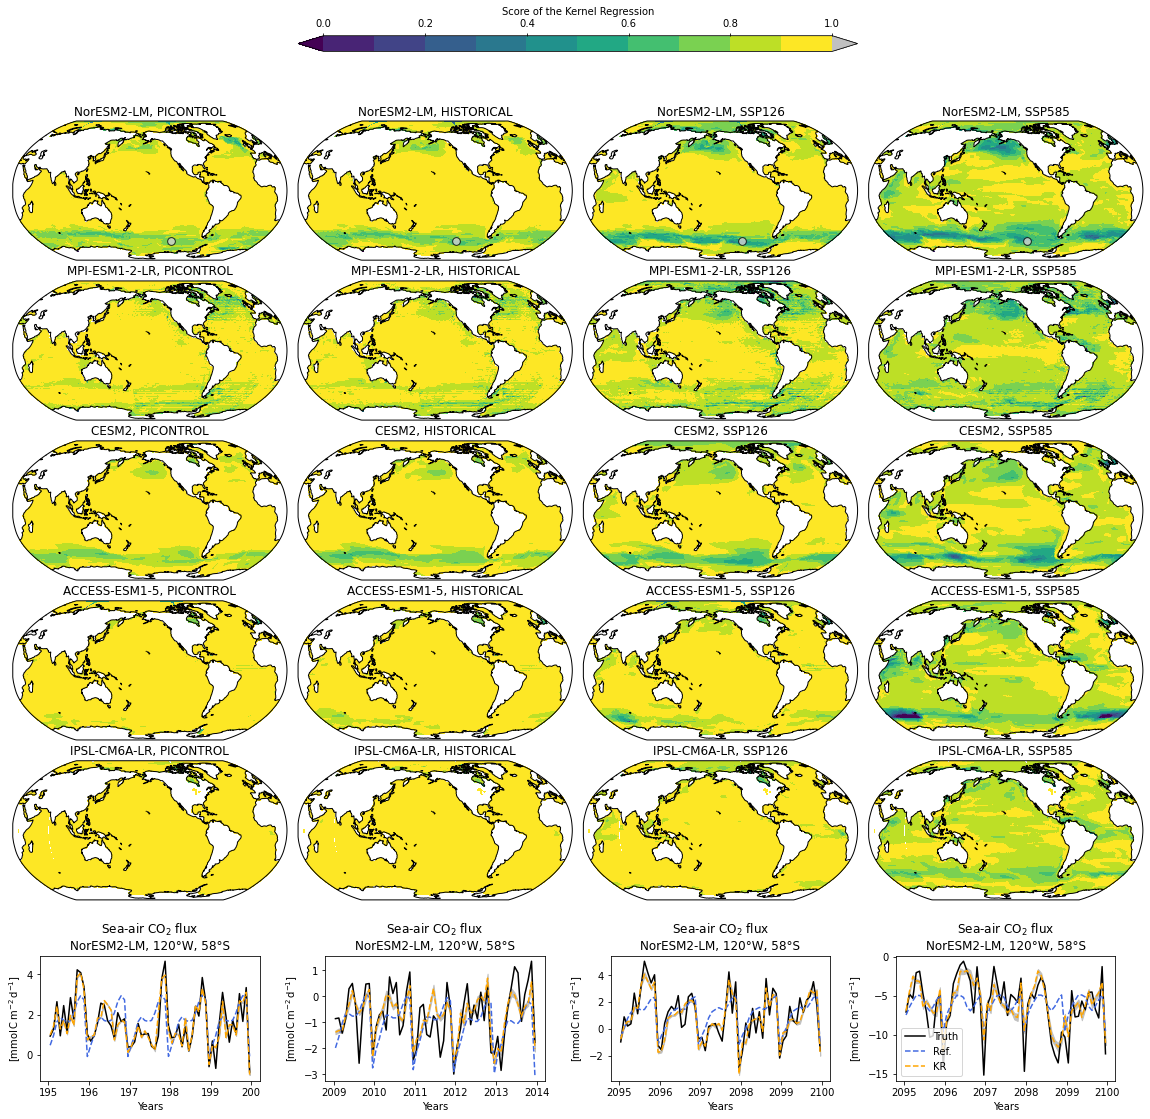

In [22]:
%%time
print(datetime.datetime.now())
print('Maps score KR: fig')

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-KR-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = len(model_list)
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)


######################
# Maps
######################

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10+1))
cmap = ListedColormap(newcolors[1:])
cmap.set_under(color=newcolors[0])
cmap.set_over(color='silver')

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())

#---------------------
# Plot score maps
#---------------------

irow = 0
for model in model_list: 
    icol = 0
    for simu in simu_list: 

        zax = ax[irow, icol]
        X = data2plot['maps'][model][simu]['X']
        Y = data2plot['maps'][model][simu]['Y']
        Z = data2plot['maps'][model][simu]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(model+', '+simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        
        # Add point
        if model == model4ts: 
            jj, ii = gridpt[0], gridpt[1]
            zax.scatter(X[jj, ii], Y[jj, ii], **kwscatter)
        #

        icol+=1

    #
    irow+=1
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.35*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='both')
cbar.set_label(r'Score of the Kernel Regression')


######################
# Time series
######################

#-----------------
# KEYWORDS DICT
#-----------------
kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwref   = dict(ls='--', label='Ref.'    , color='royalblue')

kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot timeseries
#---------------------

axts = []
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[-1, isimu].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.3*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zax = fig.add_axes([nx0, ny0, nw, nh])
    axts.append(zax)
    
    istart = -5*12
    X      = data2plot['timeseries'][vsimu]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][vsimu]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][vsimu]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][vsimu]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][vsimu]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][vsimu]['Truth'][istart:]  
       
    lltruth, = zax.plot(X, Ytruth, **kwtruth)
    llref,   = zax.plot(X, Yref  , **kwref)
    llstd    = zax.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zax.plot(X, Ykr   , **kwkr)
    
    zax.set_xlabel('Years')
    zax.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')
    
    X = data2plot['maps'][model4ts][simu]['X']
    Y = data2plot['maps'][model4ts][simu]['Y']
    jj, ii = gridpt[0], gridpt[1]
    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zax.set_title(r'Sea-air CO$_2$ flux'+'\n'+model4ts+', '+lon+', '+lat)
#

zax.legend(handles=[lltruth, llref, llkr])
#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR-'+grid+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 35s

## Fig V2

2022-07-08 10:12:40.935500
Maps score KR: fig v2
File loaded: dimred-220602-score-analysis/data2plot-maps-score-KR-360x180.pckl
Figure saved: maps-score-KR-360x180-v2.png
CPU times: user 32.2 s, sys: 3.75 s, total: 35.9 s
Wall time: 26.7 s


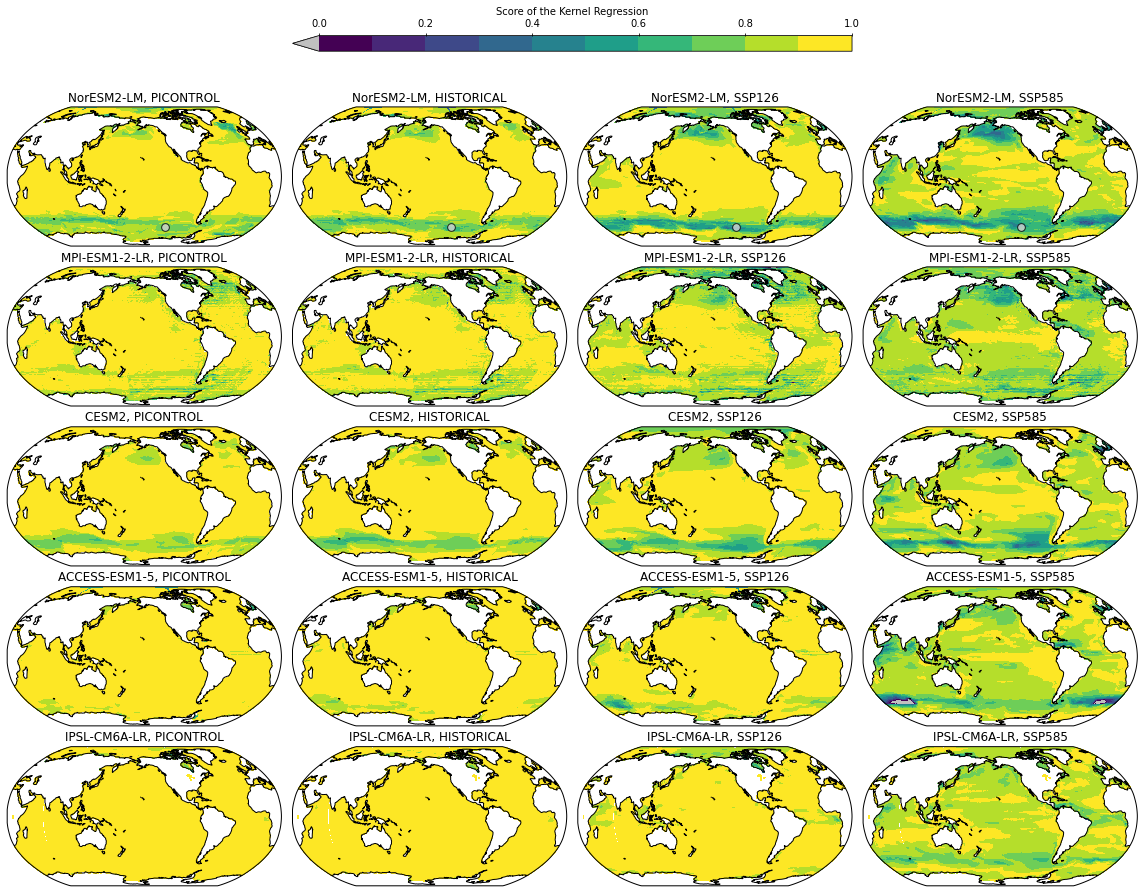

In [17]:
%%time
print(datetime.datetime.now())
print('Maps score KR: fig v2')

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-KR-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)       

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = len(model_list)
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)


#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap2.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())

#---------------------
# Plot score maps
#---------------------

irow = 0
for model in model_list: 
    icol = 0
    for simu in simu_list: 

        zax = ax[irow, icol]
        X = data2plot['maps'][model][simu]['X']
        Y = data2plot['maps'][model][simu]['Y']
        Z = data2plot['maps'][model][simu]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(model+', '+simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        
        # Add point
        if model == model4ts: 
            jj, ii = gridpt[0], gridpt[1]
            zax.scatter(X[jj, ii], Y[jj, ii], **kwscatter)
        #

        icol+=1

    #
    irow+=1
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.35*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#


#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .4*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Score of the Kernel Regression')

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR-'+grid+'-v2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 35s

# Maps score FGCO2

## Inputs

In [7]:
%%time
print(datetime.datetime.now())
print('Maps score FGCO2: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
# simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
# model_list = ['IPSL-CM6A-LR']
simu_list  = ['historical', 'ssp126', 'ssp585']
predname_list = ['dissic', 'talk', 'tos', 'sos', 'siconc', 'sfcWind', 'po4', 'fgco2']
diratmco2 = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/ATMCO2/'
atmco2_files = {
    'historical': 'Atmospheric_CO2.csv-1980-historic.txt' ,  
    'picontrol' : 'Atmospheric_CO2.csv-2400-picontrol.txt',  
    'ssp126'    : 'Atmospheric_CO2_SSP126.txt'        , 
    'ssp585'    : 'Atmospheric_CO2_SSP585.txt'          
}

# time series
model4ts = 'NorESM2-LM'
if   grid == '90x45'   : gridpt = (1*8, 1*15)
elif grid == '180x90'  : gridpt = (2*8, 2*15)
elif grid == '360x180' : gridpt = (4*8, 4*15)

2022-06-09 12:45:17.814121
Maps score FGCO2: inputs
CPU times: user 0 ns, sys: 668 µs, total: 668 µs
Wall time: 479 µs


## Compute carbon flux with fgco2 function

In [ ]:
%%time
print(datetime.datetime.now())
print('Maps score FGCO2: compute carbon flux with fgco2 function')

for model in model_list: 
    
    print("> model: "+model)

    for simu in simu_list: 

        print(">> simu: "+simu)

        #--------------------
        # Load predictors
        #--------------------

        print(">>> Load predictors")

        pred = {}
        for predname in predname_list: 

            dirname = dircmip6 + model + '/' + simu + '/'
            fname = predname + '_' + model + '_' + simu + '*.nc'
            dataset = xr.open_mfdataset(dirname + fname, use_cftime=True)
            zwpred = dataset[predname]
            pred[predname] = zwpred

        #
        pred['atmco2'] = np.loadtxt(diratmco2+atmco2_files[simu], delimiter=",")
        
        #--------------------
        # Compute fgco2 with function
        #--------------------

        print(">>> Compute fgco2 with function")
       
        #====usage====
        # fgco2, pco2, xco2, Kh, Khd = comp_fgco2_pco2(ptho, psao, sco212, alkali, phosph, psicomo, pfu10, atco2, k1k2)
        #==============

        #====inputs====
        # ptho    = temperature [degreeC]
        # psao    = salinity    [psu]
        # sco212  = dic         [kmol m-3]
        # alkali  = talk        [kmol m-3]
        # phosph  = phosphate   [kmol m-3]
        # psicomo = sea-ice fraction []
        # pfu10   = surface wind-speed [m s-1]
        # atco2   = atmospheric pCO2 [ppm]
        # k1k2    = 0 (default, Millero), 1 (Lueker et al., 2000), 2 (Sulpis et al., 2020)
        #==============

        #====outputs====
        # fgco2: CO2 flux in [kmol.m-2.s-1]
        # pco2: pco2 in seawater in [uatm]
        # xco2: dry mole fraction of CO2 in [ppm]
        # Kh: CO2 solubility for use with partial pressure in dry air 
        #     (include correction for accounting for water vapor) in [mol/l/ppm]
        # Khd: CO2 solubility for use with partial pressure in moist air
        #      (no correction for water vapor included) in [mol/l/uatm]
        #==============

        ptho    = pred['tos']    .load()
        psao    = pred['sos']    .load()
        sco212  = pred['dissic'] [:, 0].load()*1e-3
        alkali  = pred['talk']   [:, 0].load()*1e-3
        phosph  = pred['po4']    [:, 0].load()*1e-3
        psicomo = pred['siconc'] .load()/100.
        pfu10   = pred['sfcWind'].load()
        atco2   = xr.zeros_like(ptho).load()+pred['atmco2'][:, np.newaxis, np.newaxis]
        k1k2    = 0

        zwout = comp_fgco2_pco2(ptho, psao, sco212, alkali, phosph, psicomo, pfu10, atco2, k1k2)
        
        zwlon = pred['fgco2'].lon.values
        zwlat = pred['fgco2'].lat.values
        LON, LAT = np.meshgrid(zwlon, zwlat)
        
        #--------------------
        # Save datas
        #--------------------

        data2save = {
            'lon'     : LON, 
            'lat'     : LAT, 
            'cfxmodel': pred['fgco2'].values/12., 
            'cfxrec'  : zwout[0].values 
        }
        
        print(">>> Save as pickle")
        savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
        if os.path.isfile(savedfile): os.remove(savedfile)
        with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
        print("Done, file saved: "+savedfile)

    #
#

2022-06-03 17:29:30.230265
Maps score FGCO2: compute carbon flux with fgco2 function
> model: NorESM2-LM
>> simu: historical
>>> Load predictors
>>> Compute fgco2 with function
>>> Save as pickle
Done, file saved: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
>> simu: ssp126
>>> Load predictors
>>> Compute fgco2 with function
>>> Save as pickle
Done, file saved: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp126.pckl
>> simu: ssp585
>>> Load predictors
>>> Compute fgco2 with function
>>> Save as pickle
Done, file saved: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp585.pckl
> model: MPI-ESM1-2-LR
>> simu: historical
>>> Load predictors
>>> Compute fgco2 with function
>>> Save as pickle
Done, file saved: dimred-220602-score-analysis/co2flux-model-and-reconstruct-MPI-ESM1-2-LR-historical.pckl
>> simu: ssp126
>>> Load predictors
>>> Compute fgco2 with function
>>> Save as pickle
Done, file saved: 

## Maps FGCO2

File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp126.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp585.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-MPI-ESM1-2-LR-historical.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-MPI-ESM1-2-LR-ssp126.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-MPI-ESM1-2-LR-ssp585.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-CESM2-historical.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-CESM2-ssp126.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-CESM2-ssp585.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-ACCESS-ESM1-5-historical.pckl
File loaded: dimred-220602-score-anal

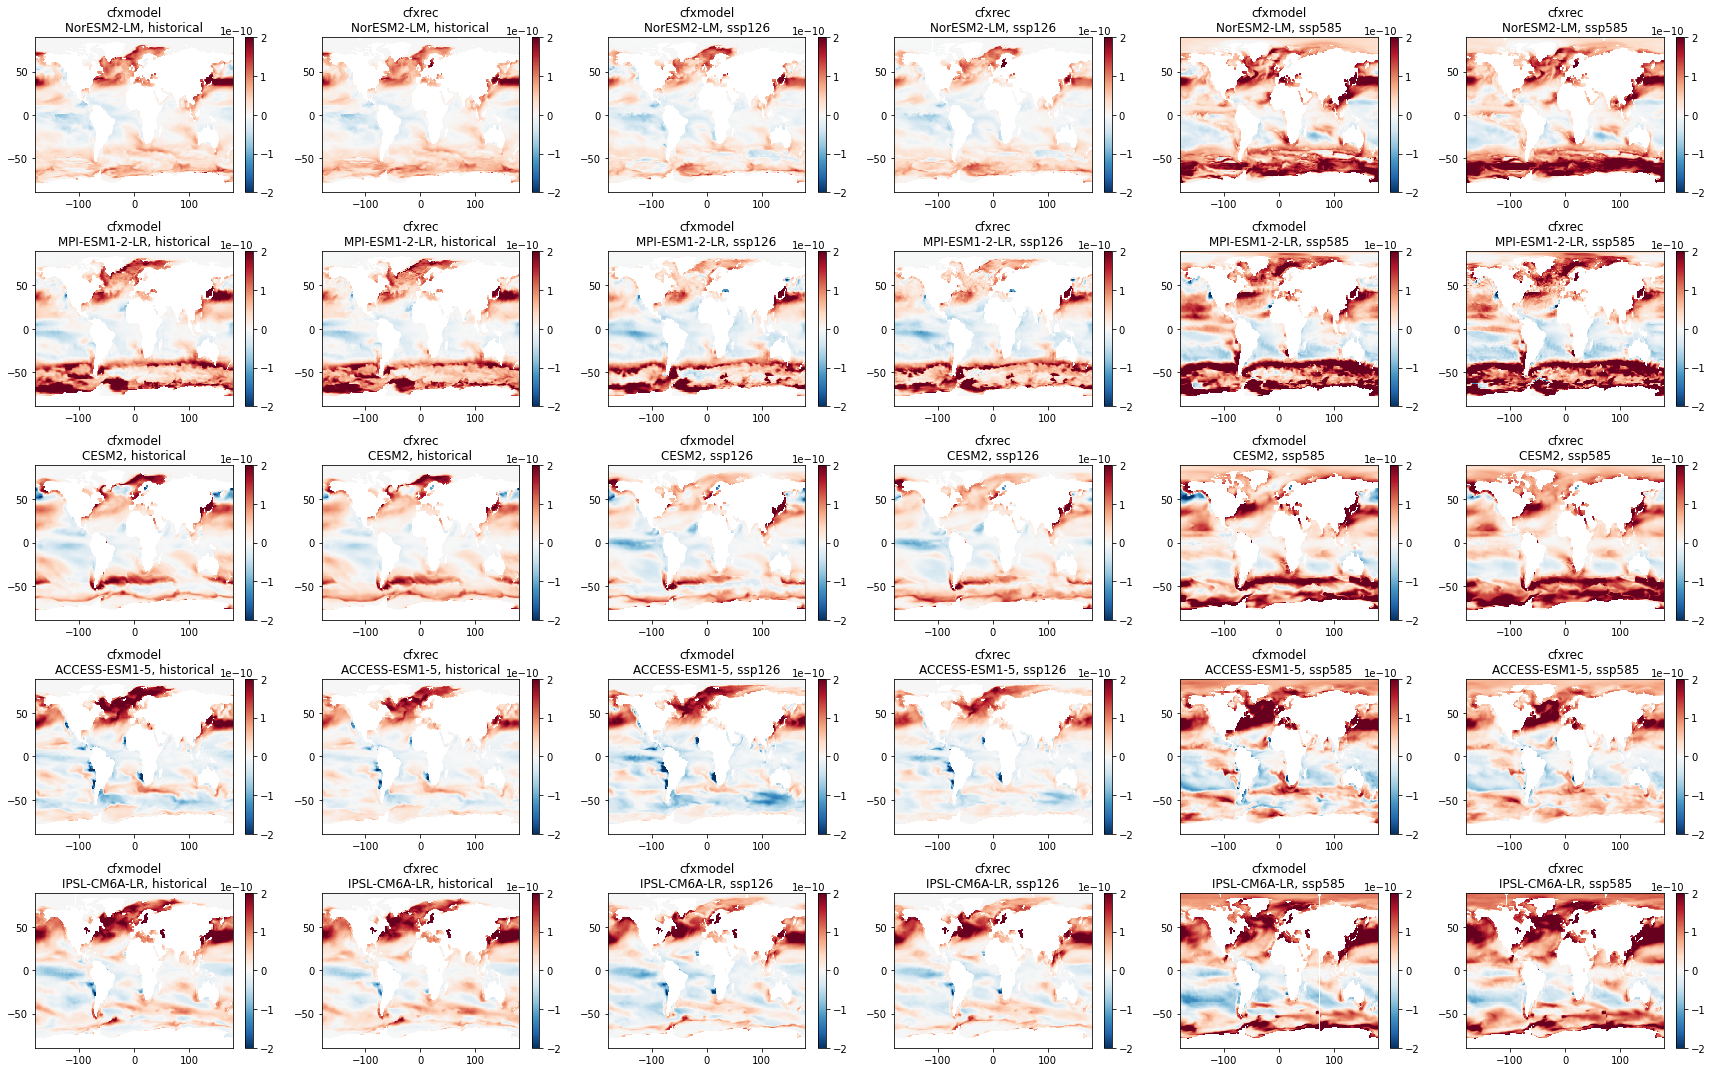

In [267]:
%%time 

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = len(model_list)
ncol = len(simu_list)*2
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow),
                       squeeze = False)
kwmap = dict(vmin=-2e-10, vmax=2e-10, cmap='RdBu_r')
it = -1

for imodel, model in enumerate(model_list): 
    icol = 0
    for isimu, simu in enumerate(simu_list): 
        
        savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)      
        
        X, Y = zwdata['lon'], zwdata['lat']

        zax = ax[imodel, icol]
        Z = zwdata['cfxmodel'][it]
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)
        plt.colorbar(pcm, ax=zax)
        zax.set_title('cfxmodel\n'+model+', '+simu)
        
        icol+=1
        zax = ax[imodel, icol]
        Z = zwdata['cfxrec'][it]
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)
        plt.colorbar(pcm, ax=zax)
        zax.set_title('cfxrec\n'+model+', '+simu)
        
        icol+=1
    #
#
fig.tight_layout()

## Compute score of FGCO2

In [301]:
%%time
print(datetime.datetime.now())
print('Maps score FGCO2: Compute score of FGCO2')

for model in model_list: 
    
    print("> model: "+model)

    for simu in simu_list: 

        print(">> simu: "+simu)
        
        savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)   
        
        cfxmodel = zwdata['cfxmodel']
        cfxrecon = zwdata['cfxrec']

        #---------------
        # Compute score
        #---------------

        score1 = np.zeros_like(cfxmodel[0])
        ground = np.logical_or(np.isnan(cfxmodel[0]), np.isnan(cfxrecon[0]))    
        for jj in np.arange(score1.shape[0]): 
            for ii in np.arange(score1.shape[1]): 
                if not ground[jj, ii]: 

                    zwmodel = cfxmodel[:, jj, ii]
                    zwrecon = cfxrecon[:, jj, ii]

                    # trend
                    t = np.linspace(0, zw.shape[0] - 1, num=zwmodel.shape[0])
                    trd = p_smooth_spline(t, zwmodel)
                    
                    # dtrd, dseas
                    zwdtrd_dseas, trdseas, seas = dtrd_dseas(zwmodel, trd)

                    # r2 score
                    score1[jj, ii] = r2_score(zwmodel - trdseas, zwrecon-trdseas)                
                else : score1[jj, ii] = np.nan
            #
        #

        data2save = {
            'lon'     : zwdata['lon'], 
            'lat'     : zwdata['lat'], 
            'score'  : score1
        }

        savedfile = dirout+'r2-score-co2flux-model-vs-reconstruct-'+model+'-'+simu+'.pckl'
        if os.path.isfile(savedfile): os.remove(savedfile)
        with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
        print("Done, file saved: "+savedfile)
    #
#

## Prepare and save data2plot

In [20]:
%%time
print(datetime.datetime.now())
print('Maps score FGCO2: prepare and save data2plot')

data2save = {'maps':{}, 'timeseries':{}}
for model in model_list: 

    print("> model:"+model)
    data2save['maps'][model] = {}
    
    for simu in simu_list: 

        print(">> simu: "+simu)
        data2save['maps'][model][simu] = {}

        #---------------
        # Maps
        #---------------

        #_______________
        # Read data

        savedfile = dirout+'r2-score-co2flux-model-vs-reconstruct-'+model+'-'+simu+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)
        X, Y, Z = zwdata['lon'], zwdata['lat'], zwdata['score']

        #_______________
        # Save maps data

        data2save['maps'][model][simu]['X'] = zwdata['lon']
        data2save['maps'][model][simu]['Y'] = zwdata['lat']
        data2save['maps'][model][simu]['Z'] = zwdata['score']
        
        #---------------
        # Time series
        #---------------
        
        if model==model4ts: 
            
            data2save['timeseries'][simu] = {}
            
            #_______________
            # Read data
            savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
            with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
            print("File loaded: "+savedfile)   
        
            #_______________
            # Extract grid point
            
            jj, ii = gridpt[0], gridpt[1]
            cfxtrue = -zwdata['cfxmodel'][:, jj, ii].squeeze()
            cfxpred = -zwdata['cfxrec']  [:, jj, ii].squeeze()

            #_______________
            # Reference for the score
            
            t = np.linspace(0, cfxtrue.shape[0] - 1, num=cfxtrue.shape[0])
            trd = p_smooth_spline(t, cfxtrue)
            cfxtrue_dtrd_dseas, trdseas, seas = dtrd_dseas(cfxtrue, trd)
            
            if simu == 'historical': ttt=np.arange(1850+1/24, 2014+1/24, 1/12)
            elif simu== 'picontrol': ttt=np.arange(1/24, 200+1/24, 1/12)
            elif simu in ['ssp126', 'ssp585']: ttt=np.arange(2014+1/24, 2100+1/24, 1/12)
            else: exit('wrong simu')
            data2save['timeseries'][simu]['time']   = ttt
            data2save['timeseries'][simu]['Ref']    = trdseas
            data2save['timeseries'][simu]['FGCO2']  = cfxpred
            data2save['timeseries'][simu]['Truth']  = cfxtrue
            
        #

    #
#

savedfile = dirout + 'data2plot-maps-score-FGCO2.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# ca. 10s

2022-06-07 13:12:48.392470
Maps score FGCO2: prepare and save data2plot
> model:NorESM2-LM
>> simu: historical
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-NorESM2-LM-historical.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
>> simu: ssp126
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-NorESM2-LM-ssp126.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp126.pckl
>> simu: ssp585
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-NorESM2-LM-ssp585.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp585.pckl
> model:MPI-ESM1-2-LR
>> simu: historical
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-MPI-ESM1-2-LR-historical.pckl
>> simu: ssp126
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-MPI-ESM

## Fig

2022-06-09 12:49:45.242973
Maps score FGCO2: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-score-FGCO2.pckl
Figure saved: maps-score-FGCO2.png
CPU times: user 23.2 s, sys: 2.41 s, total: 25.7 s
Wall time: 19.5 s


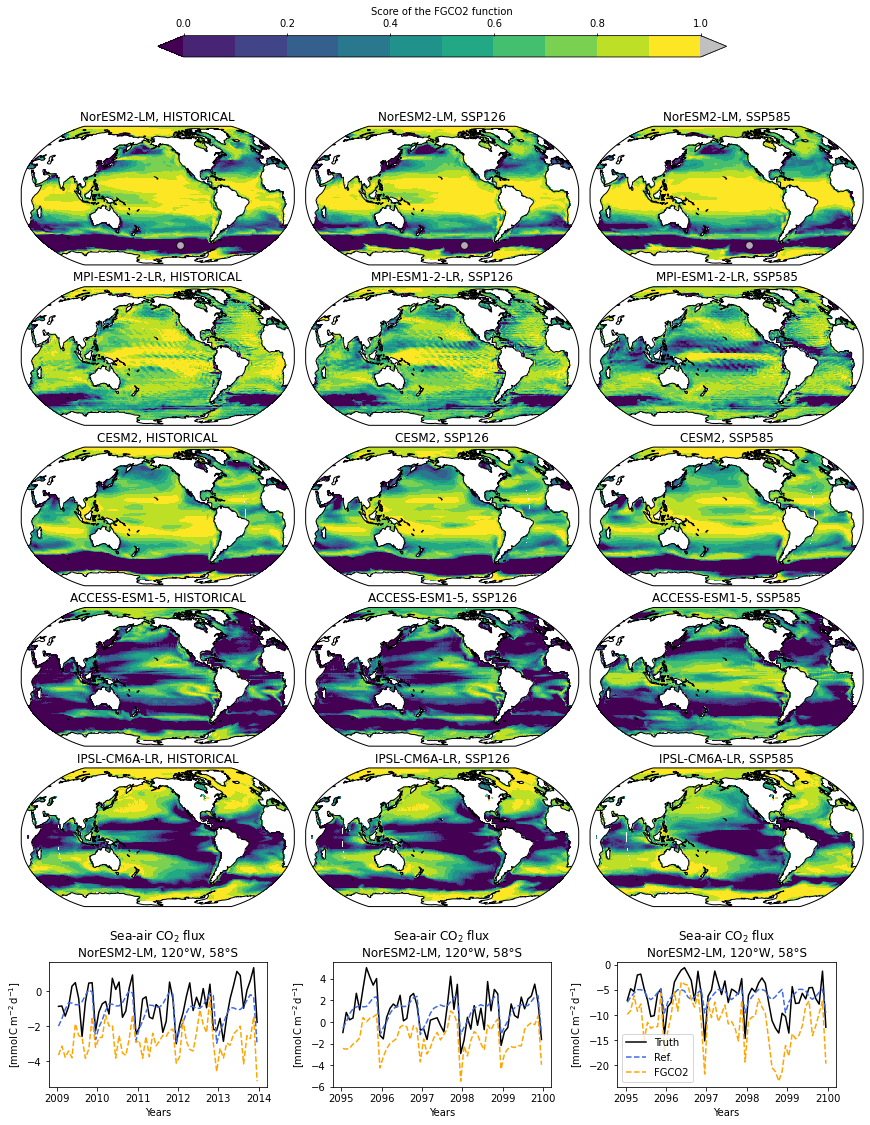

In [20]:
%%time
print(datetime.datetime.now())
print('Maps score FGCO2: fig')

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-FGCO2.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = len(model_list)
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)


######################
# Maps
######################

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10+1))
cmap = ListedColormap(newcolors[1:])
cmap.set_under(color=newcolors[0])
cmap.set_over(color='silver')

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())

#---------------------
# Plot score maps
#---------------------

irow = 0
for model in model_list: 
    icol = 0
    for simu in simu_list: 

        zax = ax[irow, icol]
        X = data2plot['maps'][model][simu]['X']
        Y = data2plot['maps'][model][simu]['Y']
        Z = data2plot['maps'][model][simu]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(model+', '+simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        
        # Add point
        if model == model4ts: 
            jj, ii = gridpt[0], gridpt[1]
            zax.scatter(X[jj, ii], Y[jj, ii], **kwscatter)
        #

        icol+=1

    #
    irow+=1
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.35*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x0+.5*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='both')
cbar.set_label(r'Score of the FGCO2 function')


######################
# Time series
######################

#-----------------
# KEYWORDS DICT
#-----------------
kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwfgco2 = dict(ls='--', label='FGCO2'   , color='orange')
kwref   = dict(ls='--', label='Ref.'    , color='royalblue')

kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot timeseries
#---------------------

axts = []
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[-1, isimu].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.3*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zax = fig.add_axes([nx0, ny0, nw, nh])
    axts.append(zax)
    
    istart = -5*12
    X      = data2plot['timeseries'][vsimu]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][vsimu]['Ref']  [istart:]  
    Yfgco2 = zfact*data2plot['timeseries'][vsimu]['FGCO2'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][vsimu]['Truth'][istart:]  
       
    lltruth, = zax.plot(X, Ytruth   , **kwtruth)
    llref,   = zax.plot(X, Yref     , **kwref)
    llfgco2, = zax.plot(X, Yfgco2   , **kwfgco2)
    
    zax.set_xlabel('Years')
    zax.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')
    
    X = data2plot['maps'][model4ts][simu]['X']
    Y = data2plot['maps'][model4ts][simu]['Y']
    jj, ii = gridpt[0], gridpt[1]
    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zax.set_title(r'Sea-air CO$_2$ flux'+'\n'+model4ts+', '+lon+', '+lat)
#
zax.legend(handles=[lltruth, llref, llfgco2])

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-FGCO2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 35s

# Maps score KR vs FGCO2

## Inputs

In [7]:
%%time
print(datetime.datetime.now())
print('Maps score KR vs ref FGCO: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
# simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
# model_list = ['IPSL-CM6A-LR']
simu_list  = ['historical', 'ssp126', 'ssp585']
predname_list = ['dissic', 'talk', 'tos', 'sos', 'siconc', 'sfcWind', 'po4', 'fgco2']
diratmco2 = '/mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/ATMCO2/'
atmco2_files = {
    'historical': 'Atmospheric_CO2.csv-1980-historic.txt' ,  
    'picontrol' : 'Atmospheric_CO2.csv-2400-picontrol.txt',  
    'ssp126'    : 'Atmospheric_CO2_SSP126.txt'        , 
    'ssp585'    : 'Atmospheric_CO2_SSP585.txt'          
}

#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# time series
model4ts = 'NorESM2-LM'
if   grid == '90x45'   : gridpt = (1*8, 1*15)
elif grid == '180x90'  : gridpt = (2*8, 2*15)
elif grid == '360x180' : gridpt = (4*8, 4*15)

2022-06-23 11:10:07.623914
Maps score KR vs ref FGCO: inputs
CPU times: user 346 µs, sys: 54 µs, total: 400 µs
Wall time: 283 µs


## Compute score of KR vs FGCO2

In [353]:
%%time
print(datetime.datetime.now())
print('Maps score KR vs ref FGCO2: compute score of KR vs FGCO2')

for model in model_list: 
    
    print("> model: "+model)

    for simu in simu_list: 

        print(">> simu: "+simu)
        
        savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)   
        
        cfxrecon = -zwdata['cfxrec']

        savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)            

        cfxtrue = zwdata['cfxtrue'].T.squeeze()
        cfxpred = zwdata['cfxpred'].T.squeeze()

        #---------------
        # Compute score
        #---------------

        score1 = np.zeros_like(cfxmodel[0])
        ground = np.logical_or( np.logical_or(np.isnan(cfxtrue[0]), np.isnan(cfxpred[0])), np.isnan(cfxrecon[0]))   
        for jj in np.arange(score1.shape[0]): 
            for ii in np.arange(score1.shape[1]): 
                if not ground[jj, ii]: 
                    zwtrue = cfxtrue[:, jj, ii]
                    zwpred = cfxpred[:, jj, ii]
                    zwrecon = cfxrecon[:, jj, ii]
                    # r2 score
                    score1[jj, ii] = r2_score(zwtrue-zwrecon, zwpred-zwrecon)                
                else : score1[jj, ii] = np.nan
            #
        #

        data2save = {
            'lon'     : zwdata['lon'].T, 
            'lat'     : zwdata['lat'].T, 
            'score'  : score1
        }

        savedfile = dirout+'r2-score-co2flux-KR-vs-FGCO2-'+model+'-'+simu+'.pckl'
        if os.path.isfile(savedfile): os.remove(savedfile)
        with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
        print("Done, file saved: "+savedfile)
    #
#

2022-06-03 22:13:53.655077
Maps score KR vs ref FGCO: compute carbon flux with fgco2 function
> model: NorESM2-LM
>> simu: historical
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
Done, file saved: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-historical.pckl
>> simu: ssp126
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp126.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp126-360x180.pckl
Done, file saved: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-ssp126.pckl
>> simu: ssp585
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp585.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-tru

## Prepare and save data2plot

In [24]:
%%time
print(datetime.datetime.now())
print('Maps score KR vs ref FGCO2: prepare and save data2plot')

data2save = {'maps':{}, 'timeseries':{}}
for model in model_list: 

    print("> model:"+model)
    data2save['maps'][model] = {}
    
    for simu in simu_list: 

        print(">> simu: "+simu)
        data2save['maps'][model][simu] = {}

        #---------------
        # Maps
        #---------------

        #_______________
        # Read data

        savedfile = dirout+'r2-score-co2flux-KR-vs-FGCO2-'+model+'-'+simu+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)
        X, Y, Z = zwdata['lon'], zwdata['lat'], zwdata['score']

        #_______________
        # Save maps data

        data2save['maps'][model][simu]['X'] = zwdata['lon']
        data2save['maps'][model][simu]['Y'] = zwdata['lat']
        data2save['maps'][model][simu]['Z'] = zwdata['score']
        
        #---------------
        # Time series
        #---------------
        
        if model==model4ts: 
            
            data2save['timeseries'][simu] = {}
            
            #_______________
            # Read data
            
            savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
            with open(savedfile, 'rb') as f1: zwdata1 = pickle.load(f1)
            print("File loaded: "+savedfile)   
            
            savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
            with open(savedfile, 'rb') as f1: zwdata2 = pickle.load(f1)
            print("File loaded: "+savedfile)            
        
            #_______________
            # Extract grid point
            
            jj, ii = gridpt[0], gridpt[1]
            
            cfxmodel = -zwdata1['cfxmodel'][:, jj, ii].squeeze()
            cfxfgco2 = -zwdata1['cfxrec']  [:, jj, ii].squeeze()
            
            cfxtrue = zwdata2['cfxtrue'][ii, jj, :].squeeze()
            cfxpred = zwdata2['cfxpred'][ii, jj, :].squeeze()
            cfxstd  = zwdata2['cfxstd' ][ii, jj, :].squeeze()

            cfxsup = cfxpred + cfxstd
            cfxinf = cfxpred - cfxstd
            
            if simu == 'historical': ttt=np.arange(1850+1/24, 2014+1/24, 1/12)
            elif simu== 'picontrol': ttt=np.arange(1/24, 200+1/24, 1/12)
            elif simu in ['ssp126', 'ssp585']: ttt=np.arange(2014+1/24, 2100+1/24, 1/12)
            else: exit('wrong simu')
            data2save['timeseries'][simu]['time']   = ttt
            data2save['timeseries'][simu]['FGCO2']  = cfxfgco2
            data2save['timeseries'][simu]['KR']     = cfxpred
            data2save['timeseries'][simu]['Truth']  = cfxtrue
            data2save['timeseries'][simu]['Model']  = cfxmodel
            data2save['timeseries'][simu]['KRsup']  = cfxsup
            data2save['timeseries'][simu]['KRinf']  = cfxinf
            
        #

    #
#

savedfile = dirout + 'data2plot-maps-score-KR-vs-FGCO2.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# ca. 10s

2022-06-07 13:17:05.902273
Maps score KR vs ref FGCO2: prepare and save data2plot
> model:NorESM2-LM
>> simu: historical
File loaded: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-historical.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
>> simu: ssp126
File loaded: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-ssp126.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp126.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-ssp126-360x180.pckl
>> simu: ssp585
File loaded: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-ssp585.pckl
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-ssp585.pckl
File loaded: /

## Fig

2022-06-09 12:53:21.235002
Maps score FGCO2: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-score-KR-vs-FGCO2.pckl
Figure saved: maps-score-KR-vs-FGCO2.png
CPU times: user 23.9 s, sys: 2.86 s, total: 26.8 s
Wall time: 19.7 s


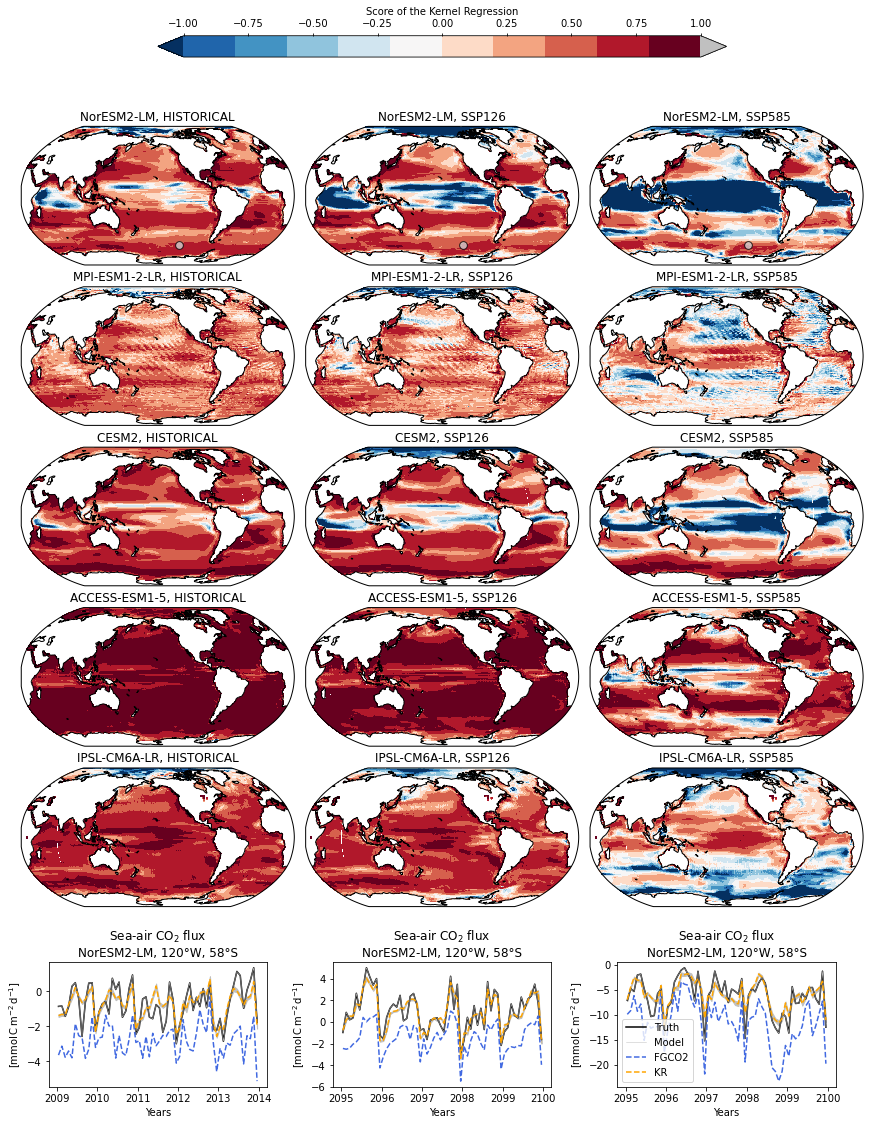

In [24]:
%%time
print(datetime.datetime.now())
print('Maps score KR vs ref FGCO2: fig')

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-KR-vs-FGCO2.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = len(model_list)
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)


######################
# Maps
######################

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('RdBu_r', 256)
newcolors = cmap(np.linspace(0, 1, 10+1))
cmap = ListedColormap(newcolors[1:])
cmap.set_under(color=newcolors[0])
cmap.set_over(color='silver')

#-----------------
# KEYWORDS DICT
#-----------------

kwmap = {'vmin':-1, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
#---------------------
# Plot score maps
#---------------------

irow = 0
for model in model_list: 
    icol = 0
    for simu in simu_list: 

        zax = ax[irow, icol]
        X = data2plot['maps'][model][simu]['X']
        Y = data2plot['maps'][model][simu]['Y']
        Z = data2plot['maps'][model][simu]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(model+', '+simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        
        # Add point
        if model == model4ts: 
            jj, ii = gridpt[0], gridpt[1]
            zax.scatter(X[jj, ii], Y[jj, ii], **kwscatter)
        #

        icol+=1

    #
    irow+=1
#
fig.tight_layout()

#---------------------
# Repositionning axes
#---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.35*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + .5*zw1.height
nw  = zw2.x0+.5*zw2.width - nx0
nh  = 0.03*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='both')
cbar.set_label(r'Score of the Kernel Regression')


######################
# Time series
######################

#-----------------
# KEYWORDS DICT
#-----------------
kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwfgco2 = dict(ls='--', label='FGCO2'   , color='royalblue')
kwmodel = dict(ls='-' , label='Model'   , lw=.5, color='silver')

kwbbox  = dict(boxstyle ="round", fc ="0.8")


#---------------------
# Plot timeseries
#---------------------

axts = []
for isimu, vsimu in enumerate(simu_list): 
    zw1 = ax[-1, isimu].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.3*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zax = fig.add_axes([nx0, ny0, nw, nh])
    axts.append(zax)
    
    istart = -5*12
    X      = data2plot['timeseries'][vsimu]['time'] [istart:]  
    Ytruth = zfact*data2plot['timeseries'][vsimu]['Truth'][istart:]  
    Ymodel = zfact*data2plot['timeseries'][vsimu]['Model'][istart:]  
    Yfgco2 = zfact*data2plot['timeseries'][vsimu]['FGCO2'][istart:]  
    Ykr    = zfact*data2plot['timeseries'][vsimu]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][vsimu]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][vsimu]['KRinf'][istart:]  
       
    lltruth, = zax.plot(X, Ytruth   , **kwtruth)
    llmodel, = zax.plot(X, Ymodel   , **kwmodel)
    llfgco2, = zax.plot(X, Yfgco2   , **kwfgco2)
    llstd    = zax.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zax.plot(X, Ykr   , **kwkr)
    
    zax.set_xlabel('Years')
    zax.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')

    X = data2plot['maps'][model4ts][simu]['X']
    Y = data2plot['maps'][model4ts][simu]['Y']
    jj, ii = gridpt[0], gridpt[1]
    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zax.set_title(r'Sea-air CO$_2$ flux'+'\n'+model4ts+', '+lon+', '+lat)
    zax.set_xlabel('Years')
    zax.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')
#

zax.legend(handles=[lltruth, llmodel, llfgco2, llkr])

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR-vs-FGCO2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 35s

## Focus on  NorESM2-LM

### Prepare and save data2plot

In [13]:
%%time
print(datetime.datetime.now())
print('Maps score KR vs ref FGCO2, focus on NorESM2-LM: prepare and save data2plot')

data2save = {'maps':{}, 'timeseries':{}}
model = 'NorESM2-LM'
    
for simu in simu_list: 

    print("> simu: "+simu)
    data2save['maps'][simu] = {}

    #---------------
    # Maps
    #---------------
    print(">> maps")
    
    #_______________
    # Read data

    savedfile = dirout+'r2-score-co2flux-KR-vs-FGCO2-'+model+'-'+simu+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)
    X1, Y1, Z1 = zwdata['lon'], zwdata['lat'], zwdata['score']

    savedfile = dirout+'r2-score-co2flux-model-vs-reconstruct-'+model+'-'+simu+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)
    X2, Y2, Z2 = zwdata['lon'], zwdata['lat'], zwdata['score']    
    
    savedfile = dirshared + 'score-std-' + model+'-'+simu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
    print("File loaded: "+savedfile)
    X3, Y3, Z3  = zwdata['lon'].T, zwdata['lat'].T, zwdata['totscor_avg'].T
 
    #_______________
    # Save maps data

    data2save['maps'][simu]['KR vs REF']={
        'X': X3, 
        'Y': Y3, 
        'Z': Z3
    }
    data2save['maps'][simu]['FGCO2 vs REF']={
        'X': X2, 
        'Y': Y2, 
        'Z': Z2
    }
    data2save['maps'][simu]['KR vs FGCO2']={
        'X': X1, 
        'Y': Y1, 
        'Z': Z1
    }

    #---------------
    # Time series
    #---------------
    print(">> time series")

    data2save['timeseries'][simu] = {}

    #_______________
    # Read data

    savedfile = dirout+'co2flux-model-and-reconstruct-'+model+'-'+simu+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata1 = pickle.load(f1)
    print("File loaded: "+savedfile)   

    savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
    with open(savedfile, 'rb') as f1: zwdata2 = pickle.load(f1)
    print("File loaded: "+savedfile)            

    #_______________
    # Extract grid point

    jj, ii = gridpt[0], gridpt[1]

    cfxmodel = -zwdata1['cfxmodel'][:, jj, ii].squeeze()
    cfxfgco2 = -zwdata1['cfxrec']  [:, jj, ii].squeeze()

    cfxtrue = zwdata2['cfxtrue'][ii, jj, :].squeeze()
    cfxpred = zwdata2['cfxpred'][ii, jj, :].squeeze()
    cfxstd  = zwdata2['cfxstd' ][ii, jj, :].squeeze()

    cfxsup = cfxpred + cfxstd
    cfxinf = cfxpred - cfxstd

    #_______________
    # Reference for the score
    t = np.linspace(0, cfxtrue.shape[0] - 1, num=cfxtrue.shape[0])
    trd = p_smooth_spline(t, cfxtrue)
    cfxtrue_dtrd_dseas, trdseas, seas = dtrd_dseas(cfxtrue, trd)

    #_______________
    # Save data    
    
    if simu == 'historical': ttt=np.arange(1850+1/24, 2014+1/24, 1/12)
    elif simu== 'picontrol': ttt=np.arange(1/24, 200+1/24, 1/12)
    elif simu in ['ssp126', 'ssp585']: ttt=np.arange(2014+1/24, 2100+1/24, 1/12)
    else: exit('wrong simu')
    data2save['timeseries'][simu]['time']   = ttt
    data2save['timeseries'][simu]['Ref']    = trdseas
    data2save['timeseries'][simu]['FGCO2']  = cfxfgco2
    data2save['timeseries'][simu]['KR']     = cfxpred
    data2save['timeseries'][simu]['Truth']  = cfxtrue
    data2save['timeseries'][simu]['Model']  = cfxmodel
    data2save['timeseries'][simu]['KRsup']  = cfxsup
    data2save['timeseries'][simu]['KRinf']  = cfxinf
    data2save['timeseries'][simu]['gridpt']  = gridpt
#

savedfile = dirout + 'data2plot-maps-score-KR-vs-FGCO2-focus-on-'+model+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# ca. 10s

2022-06-09 14:26:16.489487
Maps score KR vs ref FGCO2, focus on NorESM2-LM: prepare and save data2plot
> simu: historical
>> maps
File loaded: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-historical.pckl
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-NorESM2-LM-historical.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
>> time series
File loaded: dimred-220602-score-analysis/co2flux-model-and-reconstruct-NorESM2-LM-historical.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-historical-360x180.pckl
> simu: ssp126
>> maps
File loaded: dimred-220602-score-analysis/r2-score-co2flux-KR-vs-FGCO2-NorESM2-LM-ssp126.pckl
File loaded: dimred-220602-score-analysis/r2-score-co2flux-model-vs-reconstruct-NorESM2-LM-ssp126.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS

### Fig

2022-06-23 11:10:55.529228
Maps summarizing the score of KR: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-score-KR-vs-FGCO2-focus-on-NorESM2-LM.pckl
Figure saved: maps-score-KR-vs-FGCO2-focus-on-NorESM2-LM.png
CPU times: user 18.3 s, sys: 2.65 s, total: 20.9 s
Wall time: 14.7 s


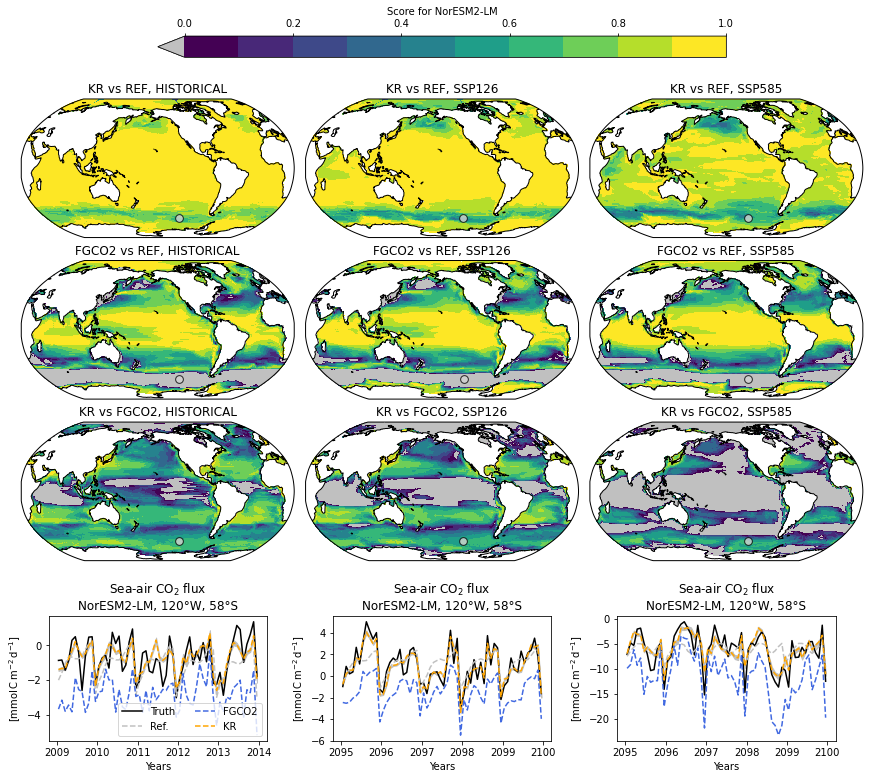

In [8]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: fig')

model = 'NorESM2-LM'

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-KR-vs-FGCO2-focus-on-'+model+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = 3
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_over(color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Maps

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
#_________________
# Time series

kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwfgco2 = dict(ls='--', label='FGCO2'   , color='royalblue')
kwref   = dict(ls='--', label='Ref.'    , color='silver')
kwmodel = dict(ls='-' , label='Model'   , lw=.5, color='silver')


kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot score maps
#---------------------

icol = 0
for simu in simu_list: 

    irow = 0
    for score in ['KR vs REF', 'FGCO2 vs REF', 'KR vs FGCO2']: 
        zax = ax[irow, icol]
        X = data2plot['maps'][simu][score]['X']
        Y = data2plot['maps'][simu][score]['Y']
        Z = data2plot['maps'][simu][score]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(score + ', '+ simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        irow+=1
    #
    
    icol+=1
#

fig.tight_layout()

# ---------------------
# Repositionning axes
# ---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.3*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Score for '+model)



#---------------------
# Plot score timeseries
#---------------------

icol = 0
axts = []
for simu in simu_list: 

    zw1 = ax[-1, icol].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.3*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
    axts.append(zaxts)

    istart = -5*12    
    X      = data2plot['timeseries'][simu]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][simu]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][simu]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][simu]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][simu]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][simu]['Truth'][istart:]  
    #Ymodel = zfact*data2plot['timeseries'][simu]['Model'][istart:]  
    Yfgco2 = zfact*data2plot['timeseries'][simu]['FGCO2'][istart:]  
    gridpt = data2plot['timeseries'][simu]['gridpt']
        
    lltruth, = zaxts.plot(X, Ytruth, **kwtruth)
    llref,   = zaxts.plot(X, Yref  , **kwref)
    llfgco2, = zaxts.plot(X, Yfgco2   , **kwfgco2)
    #llmodel, = zax.plot(X, Ymodel   , **kwmodel)
    llstd    = zaxts.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zaxts.plot(X, Ykr   , **kwkr)    
    
    zaxts.set_xlabel('Years')
    zaxts.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')

    # Add point on map
    jj, ii = gridpt[0], gridpt[1]
    X = data2plot['maps'][simu]['KR vs REF']['X']
    Y = data2plot['maps'][simu]['KR vs REF']['Y']
    ax[0, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    ax[1, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    ax[2, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)

    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zaxts.set_title(r'Sea-air CO$_2$ flux'+'\n'+model+', '+lon+', '+lat)
    
    
    icol+=1
#
axts[0].legend(handles=[lltruth, llref, llfgco2, llkr], ncol=2)

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR-vs-FGCO2-focus-on-'+model+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 14s

### Fig v2

2022-06-23 11:44:05.260092
Maps summarizing the score of KR: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-score-KR-vs-FGCO2-focus-on-NorESM2-LM.pckl
Figure saved: maps-score-KR-vs-FGCO2-focus-on-NorESM2-LM-v2.png
CPU times: user 19.7 s, sys: 3.06 s, total: 22.7 s
Wall time: 15.5 s


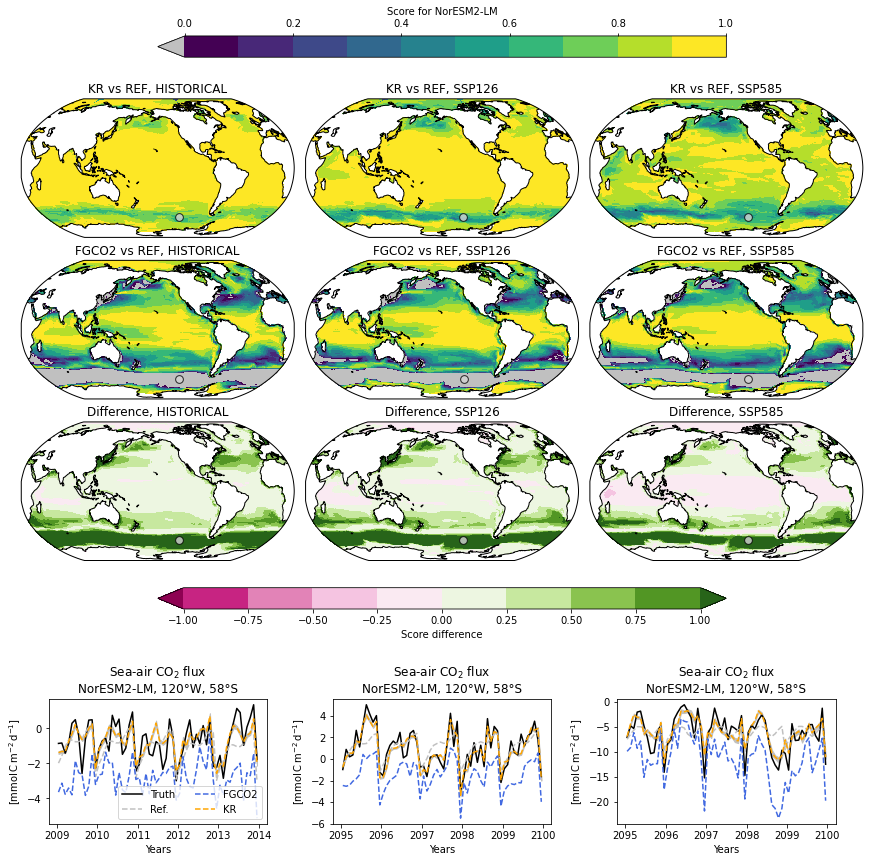

In [15]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: fig')

model = 'NorESM2-LM'

# Load data2plot
savedfile = dirout + 'data2plot-maps-score-KR-vs-FGCO2-focus-on-'+model+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = 3
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')
cmap.set_over(color=newcolors[-1])
cmap.set_bad(color='silver', alpha=0)

cmap2 = cm.get_cmap('PiYG', 256)
newcolors = cmap2(np.linspace(0, 1, 10))
cmap2 = ListedColormap(newcolors[1:-1])
cmap2.set_under(color=newcolors[0])
cmap2.set_over(color=newcolors[-1])
cmap2.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Maps

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwmap2 = {'vmin':-1, 'vmax':1, 'cmap':cmap2, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
#_________________
# Time series

kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwfgco2 = dict(ls='--', label='FGCO2'   , color='royalblue')
kwref   = dict(ls='--', label='Ref.'    , color='silver')
kwmodel = dict(ls='-' , label='Model'   , lw=.5, color='silver')


kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot score maps
#---------------------

icol = 0
for simu in simu_list: 

    irow = 0
    for score in ['KR vs REF', 'FGCO2 vs REF']: 
        zax = ax[irow, icol]
        X = data2plot['maps'][simu][score]['X']
        Y = data2plot['maps'][simu][score]['Y']
        Z = data2plot['maps'][simu][score]['Z']
        pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
        zax.set_title(score + ', '+ simu.upper())
        zax.coastlines()
        # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
        irow+=1
    #

    # DIFF
    zax = ax[irow, icol]
    X = data2plot['maps'][simu]['KR vs REF']['X']
    Y = data2plot['maps'][simu]['KR vs REF']['Y']
    Z = data2plot['maps'][simu]['KR vs REF']['Z'] - data2plot['maps'][simu]['FGCO2 vs REF']['Z']            
    pcm2 = zax.pcolormesh(X, Y, Z, **kwmap2)    
    zax.set_title('Difference, '+ simu.upper())
    zax.coastlines()
    
    icol+=1
#

fig.tight_layout()

# ---------------------
# Repositionning axes
# ---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.3*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 0].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Score for '+model)

zw1 = ax[-1, 0].get_position()
zw2 = ax[-1, 2].get_position()
nx0 = zw1.x0 + .5*zw1.width
ny0 = zw1.y0 - .35*zw1.height
nw  = zw2.x0 + .5*zw2.width - nx0
nh  = 0.05*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm2, cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='both')
cbar.set_label(r'Score difference')


#---------------------
# Plot score timeseries
#---------------------

icol = 0
axts = []
for simu in simu_list: 

    zw1 = ax[-1, icol].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.9*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
    axts.append(zaxts)

    istart = -5*12    
    X      = data2plot['timeseries'][simu]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][simu]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][simu]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][simu]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][simu]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][simu]['Truth'][istart:]  
    #Ymodel = zfact*data2plot['timeseries'][simu]['Model'][istart:]  
    Yfgco2 = zfact*data2plot['timeseries'][simu]['FGCO2'][istart:]  
    gridpt = data2plot['timeseries'][simu]['gridpt']
        
    lltruth, = zaxts.plot(X, Ytruth, **kwtruth)
    llref,   = zaxts.plot(X, Yref  , **kwref)
    llfgco2, = zaxts.plot(X, Yfgco2   , **kwfgco2)
    #llmodel, = zax.plot(X, Ymodel   , **kwmodel)
    llstd    = zaxts.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zaxts.plot(X, Ykr   , **kwkr)    
    
    zaxts.set_xlabel('Years')
    zaxts.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')

    # Add point on map
    jj, ii = gridpt[0], gridpt[1]
    X = data2plot['maps'][simu]['KR vs REF']['X']
    Y = data2plot['maps'][simu]['KR vs REF']['Y']
    ax[0, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    ax[1, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)
    ax[2, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)

    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zaxts.set_title(r'Sea-air CO$_2$ flux'+'\n'+model+', '+lon+', '+lat)
    
    
    icol+=1
#
axts[0].legend(handles=[lltruth, llref, llfgco2, llkr], ncol=2)

#---------------------
# Save figure
#---------------------

fignam = 'maps-score-KR-vs-FGCO2-focus-on-'+model+'-v2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 14s

# Maps summarizing the score of KR

## Inputs

In [23]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: inputs')

# model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CNRM-ESM2-1', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
model_list = ['NorESM2-LM', 'MPI-ESM1-2-LR', 'CESM2', 'ACCESS-ESM1-5', 'IPSL-CM6A-LR']
simu_list  = ['picontrol', 'historical', 'ssp126', 'ssp585']
#grid_list  = ['90x45', '180x90']
grid  = '360x180'

# time series
gridpt_base = [(9, 65), (9, 75), (9, 80), (9, 20), (15, 10), (25, 10)]
if   grid == '90x45'   : gridpt_list = [(ii*1, jj*1) for ii, jj in gridpt_base]
elif grid == '180x90'  : gridpt_list = [(ii*2, jj*2) for ii, jj in gridpt_base]
elif grid == '360x180' : gridpt_list = [(ii*4, jj*4) for ii, jj in gridpt_base]
#gridpt = (38, 238)

2022-12-05 19:07:29.935274
Maps summarizing the score of KR: inputs
CPU times: user 199 µs, sys: 272 µs, total: 471 µs
Wall time: 287 µs


## Prepare and save data2plot

In [24]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: prepare and save data2plot')

data2save = {'maps':{}, 'timeseries':{}}


for simu in simu_list: 
    
    print(">> simu: "+simu)

    ################
    # MAPS
    ################

    data2save['maps'][simu] = {}
    
    #_______________
    # Get minimum score accross models
    
    zw = []
    for model in model_list: 
        savedfile = dirshared + 'score-std-' + model+'-'+simu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)
        zw.append(zwdata['totscor_avg'].T)
    #
    zw = np.array(zw)
    
    minscore = np.nanmin(zw, axis=0)
    nans = np.isnan(minscore)
    worsemodel = np.array(np.argmin(zw, axis=0), dtype=np.float)
    worsemodel[nans] = np.nan
    
    #_______________
    # Adjust X and Y for pcolor
    
    X = zwdata['lon'].T
    Y = zwdata['lat'].T

    #_______________
    # Save data
    
    data2save['maps'][simu]['X'] = X
    data2save['maps'][simu]['Y'] = Y
    data2save['maps'][simu]['min score']          = minscore
    data2save['maps'][simu]['worse model']        = worsemodel
    data2save['maps'][simu]['model list ordered'] = model_list
   
    ################
    # TIME SERIES
    ################
    
    data2save['timeseries'][simu] = {}
    
    for igridpt, gridpt in enumerate(gridpt_list): 
        
        data2save['timeseries'][simu]['gridpt '+str(igridpt)] = {
            
        }
        #_______________
        # Get worse model in gridpt
        jj, ii = gridpt[0], gridpt[1]
        imodel = np.int(worsemodel[gridpt[0], gridpt[1]])
        model = model_list[imodel]

        #_______________
        # Read data
        savedfile = dirshared + 'cfx-true-pred-std-' + model+'-'+simu+'-'+grid+'.pckl'
        with open(savedfile, 'rb') as f1: zwdata = pickle.load(f1)
        print("File loaded: "+savedfile)            

        #_______________
        # Extract grid point
        cfxtrue = zwdata['cfxtrue'][ii, jj, :].squeeze()
        cfxpred = zwdata['cfxpred'][ii, jj, :].squeeze()
        cfxstd  = zwdata['cfxstd' ][ii, jj, :].squeeze()
        cfxsup = cfxpred + cfxstd
        cfxinf = cfxpred - cfxstd

        #_______________
        # Reference for the score
        t = np.linspace(0, cfxtrue.shape[0] - 1, num=cfxtrue.shape[0])
        trd = p_smooth_spline(t, cfxtrue)
        cfxtrue_dtrd_dseas, trdseas, seas = dtrd_dseas(cfxtrue, trd)

        #_______________
        # Save data

        if simu == 'historical': ttt=np.arange(1850+1/24, 2014+1/24, 1/12)
        elif simu== 'picontrol': ttt=np.arange(1650+1/24, 1850+1/24, 1/12)
        elif simu in ['ssp126', 'ssp585']: ttt=np.arange(2014+1/24, 2100+1/24, 1/12)
        else: exit('wrong simu')
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['time']   = ttt
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['Ref']    = trdseas
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['KR']     = cfxpred
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['KRsup']  = cfxsup
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['KRinf']  = cfxinf
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['Truth']  = cfxtrue
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['model name']  = model
        data2save['timeseries'][simu]['gridpt '+str(igridpt)]['gridpt']  = gridpt
#

savedfile = dirout + 'data2plot-maps-summarize-score-KR-'+grid+'.pckl'
if os.path.isfile(savedfile): os.remove(savedfile)
with open(savedfile, 'wb') as f1:pickle.dump(data2save, f1)
print("File saved: "+savedfile)        

# ca. 50s

2022-12-05 19:07:36.909630
Maps summarizing the score of KR: prepare and save data2plot
>> simu: picontrol
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-MPI-ESM1-2-LR-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-CESM2-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-ACCESS-ESM1-5-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-IPSL-CM6A-LR-picontrol-360x180.pckl


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: All-NaN slice encountered


File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-NorESM2-LM-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-CESM2-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-CESM2-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-MPI-ESM1-2-LR-picontrol-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/cfx-true-pred-std-MPI-ESM1-2-LR-picontrol-360x180.pckl
>> simu: historical
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/score-std-NorESM2-LM-historical-360x180.pckl
File loaded: /mnt/reef-ns1002k/daco/MY_JUPYTER_NOTEBOOKS/DIM-RED/SHARED-DATAS/sco

## Fig

2022-12-05 18:55:11.064144
Maps summarizing the score of KR: fig
File loaded: dimred-220602-score-analysis/data2plot-maps-summarize-score-KR-360x180.pckl
Figure saved: maps-summarize-score-KR-360x180.png
CPU times: user 16.8 s, sys: 2.44 s, total: 19.2 s
Wall time: 13.5 s


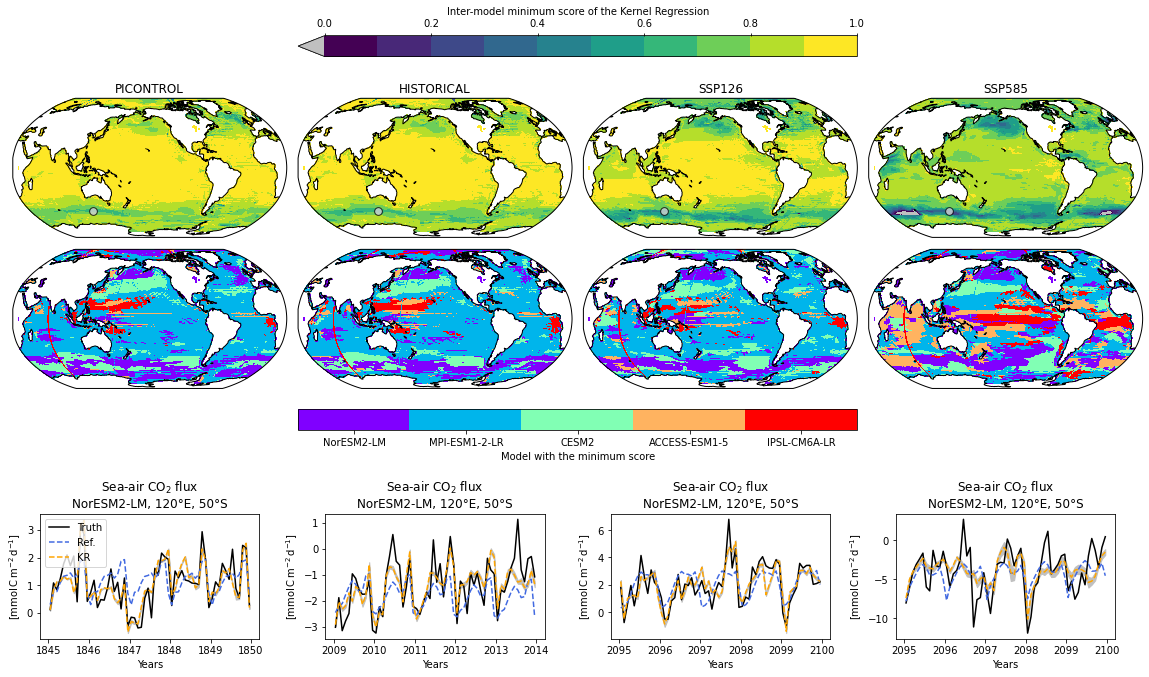

In [15]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: fig')

# Load data2plot
savedfile = dirout + 'data2plot-maps-summarize-score-KR-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
gridpt_name = 'gridpt 1'

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = 2
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap2 = cm.get_cmap('rainbow', 256)
newcolors = cmap2(np.linspace(0, 1, len(model_list)))
cmap2 = ListedColormap(newcolors)
cmap2.set_under(color='silver')
cmap2.set_over(color='silver')
cmap2.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Maps

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwmapworsemodel = {'vmin':-.5, 'vmax':len(model_list)-.5, 'cmap':cmap2, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
#_________________
# Time series

kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwref   = dict(ls='--', label='Ref.'    , color='royalblue')

kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot score maps
#---------------------

icol = 0
for simu in simu_list: 

    #_________________
    # Maps score
    
    irow = 0
    zax = ax[irow, icol]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    Z = data2plot['maps'][simu]['min score']
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
    zax.set_title(simu.upper())
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    
    #_________________
    # Maps worse model
    
    irow = 1
    zax = ax[irow, icol]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    Z = data2plot['maps'][simu]['worse model']
    pcm2 = zax.pcolormesh(X, Y, Z, **kwmapworsemodel)    
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    icol+=1
#

fig.tight_layout()

# ---------------------
# Repositionning axes
# ---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.25*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.1*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Inter-model minimum score of the Kernel Regression')

zw1 = ax[1, 1].get_position()
zw2 = ax[1, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y0 - .3*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.1*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm2, cax=cax, orientation='horizontal', \
                    ticklocation='bottom', extend='neither', \
                    ticks = np.arange(len(data2plot['maps'][simu]['model list ordered'])))
cbar.set_label(r'Model with the minimum score')
cbar.set_ticklabels(data2plot['maps'][simu]['model list ordered'])


#---------------------
# Plot score timeseries
#---------------------

icol = 0
axts = []
for simu in simu_list: 

    zw1 = ax[1, icol].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.8*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
    axts.append(zaxts)

    istart = -5*12    
    X      = data2plot['timeseries'][simu][gridpt_name]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][simu][gridpt_name]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][simu][gridpt_name]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][simu][gridpt_name]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][simu][gridpt_name]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][simu][gridpt_name]['Truth'][istart:]  
    gridpt = data2plot['timeseries'][simu][gridpt_name]['gridpt']
    modelname = data2plot['timeseries'][simu][gridpt_name]['model name']
        
    lltruth, = zaxts.plot(X, Ytruth, **kwtruth)
    llref,   = zaxts.plot(X, Yref  , **kwref)
    llstd    = zaxts.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zaxts.plot(X, Ykr   , **kwkr)

    zaxts.set_xlabel('Years')
    zaxts.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')

    # Add point on map
    jj, ii = gridpt[0], gridpt[1]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    ax[0, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)

    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zaxts.set_title(r'Sea-air CO$_2$ flux'+'\n'+modelname+', '+lon+', '+lat)
    
    
    icol+=1
#
axts[0].legend(handles=[lltruth, llref, llkr])

#---------------------
# Save figure
#---------------------

fignam = 'maps-summarize-score-KR-'+grid+'.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 12s

## Fig V2

2022-07-08 10:08:25.139189
Maps summarizing the score of KR: fig v2
File loaded: dimred-220602-score-analysis/data2plot-maps-summarize-score-KR-360x180.pckl
Figure saved: maps-summarize-score-KR-360x180-v2.png
CPU times: user 11.8 s, sys: 1.98 s, total: 13.8 s
Wall time: 9.19 s


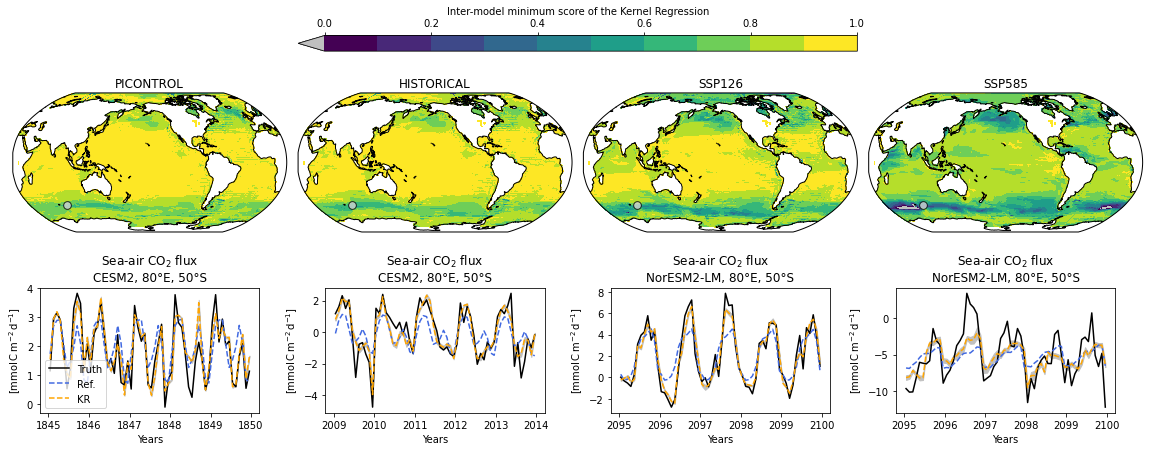

In [14]:
%%time
print(datetime.datetime.now())
print('Maps summarizing the score of KR: fig v2')

# Load data2plot
savedfile = dirout + 'data2plot-maps-summarize-score-KR-'+grid+'.pckl'
with open(savedfile, 'rb') as f1: data2plot = pickle.load(f1)
print("File loaded: "+savedfile)        

zfact = 1e6*3600*24 # kmol/m2/s -> mmol/m2/d
gridpt_name = 'gridpt 1'

#-----------------
# FIGURE PARAM
#-----------------

cm2in = 1/2.54 # converting factor cm to inch 
xfsize, yfsize = 4, 3
nrow = 1
ncol = len(simu_list)
ccrsproj = ccrs.Robinson(central_longitude=-155)
fig, ax = plt.subplots(nrow, ncol, figsize=(xfsize*ncol,yfsize*nrow), 
                       subplot_kw=dict(projection=ccrsproj),
                       squeeze = False)

#-----------------
# CREATE CUSTOM CMAP
#-----------------

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap = cm.get_cmap('viridis', 256)
newcolors = cmap(np.linspace(0, 1, 10))
cmap = ListedColormap(newcolors[:])
cmap.set_under(color='silver')
cmap.set_over(color='silver')

from matplotlib.colors import ListedColormap
from matplotlib import cm
cmap2 = cm.get_cmap('rainbow', 256)
newcolors = cmap2(np.linspace(0, 1, len(model_list)))
cmap2 = ListedColormap(newcolors)
cmap2.set_under(color='silver')
cmap2.set_over(color='silver')
cmap2.set_bad(color='silver', alpha=0)

#-----------------
# KEYWORDS DICT
#-----------------

#_________________
# Maps

kwmap = {'vmin':0, 'vmax':1, 'cmap':cmap, \
         'transform':ccrs.PlateCarree() }
kwmapworsemodel = {'vmin':-.5, 'vmax':len(model_list)-.5, 'cmap':cmap2, \
         'transform':ccrs.PlateCarree() }
kwscatter = dict(edgecolor='k', facecolor='lightgray', alpha = .8, s=60, \
                 transform=ccrs.PlateCarree())
#_________________
# Time series

kwtruth = dict(ls='-' , label='Truth'   , color='k')
kwkr    = dict(ls='--', label='KR'      , color='orange')
kwstd   = dict(label='$\pm$ std'        , color='silver')
kwref   = dict(ls='--', label='Ref.'    , color='royalblue')

kwbbox  = dict(boxstyle ="round", fc ="0.8")

#---------------------
# Plot score maps
#---------------------

icol = 0
for simu in simu_list: 

    #_________________
    # Maps score
    
    irow = 0
    zax = ax[irow, icol]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    Z = data2plot['maps'][simu]['min score']
    pcm = zax.pcolormesh(X, Y, Z, **kwmap)    
    zax.set_title(simu.upper())
    zax.coastlines()
    # gl = zax.gridlines(crs=ccrs.PlateCarree(), linewidth=1)
    
    icol+=1
#

fig.tight_layout()

# ---------------------
# Repositionning axes
# ---------------------

for irow, axrow in enumerate(ax[1:]): 
    for icol, zax in enumerate(axrow): 
        zw1 = zax.get_position()
        ny0 = zw1.y0 + (irow+1)*0.25*zw1.height
        zax.set_position([zw1.x0, ny0, zw1.width, zw1.height])
    #
#

#---------------------
# Colorbar
#---------------------

zw1 = ax[0, 1].get_position()
zw2 = ax[0, 2].get_position()
nx0 = zw1.x0
ny0 = zw1.y1 + .3*zw1.height
nw  = zw2.x1 - nx0
nh  = 0.15*nw
cax = fig.add_axes([nx0, ny0, nw, nh])
cbar = fig.colorbar(pcm, cax=cax, orientation='horizontal', \
                    ticklocation='top', extend='min')
cbar.set_label(r'Inter-model minimum score of the Kernel Regression')

#---------------------
# Plot score timeseries
#---------------------

icol = 0
axts = []
for simu in simu_list: 

    zw1 = ax[0, icol].get_position()
    nx0 = zw1.x0+.1*zw1.width
    ny0 = zw1.y0 - 1.3*zw1.height
    nw  = .8*zw1.width
    nh  = .9*zw1.height
    zaxts = fig.add_axes([nx0, ny0, nw, nh]) 
    axts.append(zaxts)

    istart = -5*12    
    X      = data2plot['timeseries'][gridpt_name][simu]['time'] [istart:]  
    Yref   = zfact*data2plot['timeseries'][simu][gridpt_name]['Ref']  [istart:]  
    Ykr    = zfact*data2plot['timeseries'][simu][gridpt_name]['KR']   [istart:]  
    Ykrsup = zfact*data2plot['timeseries'][simu][gridpt_name]['KRsup'][istart:]   
    Ykrinf = zfact*data2plot['timeseries'][simu][gridpt_name]['KRinf'][istart:]  
    Ytruth = zfact*data2plot['timeseries'][simu][gridpt_name]['Truth'][istart:]  
    gridpt = data2plot['timeseries'][simu][gridpt_name]['gridpt']
    modelname = data2plot['timeseries'][simu][gridpt_name]['model name']
        
    lltruth, = zaxts.plot(X, Ytruth, **kwtruth)
    llref,   = zaxts.plot(X, Yref  , **kwref)
    llstd    = zaxts.fill_between(X, Ykrinf, Ykrsup, **kwstd)
    llkr,    = zaxts.plot(X, Ykr   , **kwkr)

    zaxts.set_xlabel('Years')
    zaxts.set_ylabel('[mmol$\,$C$\,$m$^{-2}\,$d$^{-1}$]')

    # Add point on map
    jj, ii = gridpt[0], gridpt[1]
    X = data2plot['maps'][simu]['X']
    Y = data2plot['maps'][simu]['Y']
    ax[0, icol].scatter(X[jj, ii], Y[jj, ii], **kwscatter)

    yyy, xxx = Y[jj, ii], X[jj, ii]
    if yyy < 0: lat='%.f°S'%(-yyy)
    else : lat='%.f°N'%(yyy)
    if xxx < 0: lon='%.f°W'%(-xxx)
    else : lon='%.f°E'%(xxx)
    zaxts.set_title(r'Sea-air CO$_2$ flux'+'\n'+modelname+', '+lon+', '+lat)
    
    
    icol+=1
#
axts[0].legend(handles=[lltruth, llref, llkr])

#---------------------
# Save figure
#---------------------

fignam = 'maps-summarize-score-KR-'+grid+'-v2.png'
fig.savefig(dirout+fignam, bbox_inches='tight')
print('Figure saved: '+fignam)

# 12s